<a href="https://colab.research.google.com/github/TGOK-RUG/Bachelor_research_project/blob/main/Final_model_H2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Functions**

In [17]:
# --- Quarter-hourly Simulation: Battery + Hydrogen Storage
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- Constants ---
R = 8.314  # J/mol·K
Z = 1.1  # compressibility factor for hydrogen
M_H2 = 2.016e-3  # kg/mol
LHV_H2 = 119.96e6   # J/kg

# --- System Parameters ---
H_production_eff = 0.75
H_consumption_eff = 0.7

# --- Cavern Parameters ---
max_pressure_difference = 1e6 / (24 *4) # Pa per quarter
#cavern_volume = 1e6 #40e6  # m³
cavern_pressure_max = 198e5# 198e5  # Pa,
cavern_pressure_min = 84e5#84e5   # Pa
cavern_temp = 323  # K

# --- Time Conversion ---
SECONDS_PER_QUARTER = 900  # 15 minutes

# --- Functions ---
def mass_storage(pressure,cavern_volume):
    n = (pressure * cavern_volume) / (Z * R * cavern_temp)
    return n * M_H2  # kg


def hydrogen_energy(mass_kg):
    return mass_kg * (LHV_H2 / 1e6)  # MJ

def pressure_from_mass(mass_kg,cavern_volume):
    n = mass_kg / M_H2
    if cavern_volume == 0:
        print(f"[WARNING] cavern volume = {cavern_volume}.          (mass = {mass_kg})")
        cavern_volume = 1e-6
    return abs((n * Z * R * cavern_temp) / cavern_volume)  # Pa

def volume_from_mass(mass_kg):
    n = mass_kg / M_H2
    standard_pressure = 101325  # Pa
    standard_temp = 273.15  # K
    return abs((n * Z * R * standard_temp) / standard_pressure)  # m³

def max_flow_rate(max_pressure_difference,cavern_volume):
    return max_pressure_difference * (cavern_volume * M_H2) / (Z * R * cavern_temp)  # kg/ 15min

def H2_production_rate(energy_MW, max_injection_rate):
    energy_MJ = energy_MW * SECONDS_PER_QUARTER  # MJ
    H2_energy = min(energy_MJ * H_production_eff, max_injection_rate * (LHV_H2 / 1e6))
    return H2_energy / (LHV_H2 / 1e6)  # kg

def H2_consumption_rate(energy_MW, max_withdrawal_rate):
    energy_MJ = abs(energy_MW) * SECONDS_PER_QUARTER  # MJ
    H2_energy = min(energy_MJ / H_consumption_eff, max_withdrawal_rate * (LHV_H2 / 1e6))
    return H2_energy / (LHV_H2 / 1e6)  # kg

def transform_and_sort_below_threshold(arr, threshold=-10):
    """
    Transforms the input array by:
    1. Setting all values >= threshold to 0.
    2. Taking the absolute value of all elements.
    3. Sorting the result in descending order.

    Parameters:
    - arr (list or np.ndarray): Input array of numbers.
    - threshold (float): Values >= threshold will be set to 0 (default: -10).

    Returns:
    - np.ndarray: Transformed array with the same length, sorted descending.
    """
    # Convert to NumPy array if input is a list
    arr = np.asarray(arr)

    # Step 1: Zero out values >= threshold
    masked_arr = np.where(arr >= threshold, 0, arr)

    # Step 2: Take absolute values
    abs_arr = np.abs(masked_arr)

    # Step 3: Sort in descending order
    sorted_arr = np.sort(abs_arr)[::-1]

    return sorted_arr

def tsc(arr_np, arr_nd):
    # Clip production to demand (if production > demand, set it to demand)
    arr_np_c = np.where(arr_np >= arr_nd, arr_nd, arr_np)
    # Calculate fraction of demand met
    fraction = arr_np_c / arr_nd
    #print(f"fraction:{fraction} !  arr_np_c: {arr_np_c} ! arr_nd: {arr_nd}")

    # Deficiency fraction (0 = no shortage, 1 = total shortage)
    new = 1 - fraction  # Values between 0 and 1

    # Sort deficiencies in descending order
    sorted_new = np.sort(new)[::-1]
    return sorted_new



# --- Simulation Function ---
def simulate_storage(df,cavern_volume,battery_storage_max, ppting):
    quarters = len(df)

    if cavern_volume == 0:
        print(f"[WARNING (wrong begin input)] cavern volume = {cavern_volume} ---------------------")
        cavern_volume = 1e-6

    system_capacity_max = mass_storage(cavern_pressure_max,cavern_volume)
    system_capacity_min = mass_storage(cavern_pressure_min,cavern_volume)

    mass_H2 = np.full(quarters, system_capacity_min)
    available_mass_H2 = np.zeros(quarters)
    pressure = np.zeros(quarters)
    energy_stored = np.zeros(quarters)
    b_energy_stored_GWh = np.zeros(quarters)
    net_power = np.zeros(quarters)
    H2_mass_in = np.zeros(quarters)
    H2_mass_out = np.zeros(quarters)
    final_energy_output_normal = np.zeros(quarters)



    #battery_storage_max = 20000000000  # MJ
    battery_storage_min = battery_storage_max * 0.1       # MJ
    C_rate = 0.25 # fraction of battery capacity per hour
    P_max = C_rate * battery_storage_max / 4 # Maxmimal charge and discharge rate per 15 minutes
    battery_efficiency = 0.95
    battery_loss = 0.000003455   # 1% per month
    battery_capacity_loss = 7.49e-6 # 30 % over 10 years, 3% per year, 7.59e-3% per day, 7.911e(-5) per 15min

    battery_storage = np.full(quarters, battery_storage_min)
    battery_storage_line_max = np.full(quarters, battery_storage_max)
    battery_storage_line_min = np.full(quarters, battery_storage_min)
    available_battery_storage = np.zeros(quarters)
    energy_input_to_battery = np.zeros(quarters)
    energy_output_from_battery = np.zeros(quarters)

    system_capacity_line_max = np.full(quarters, system_capacity_max)
    system_capacity_line_min = np.full(quarters, system_capacity_min)

    Hydrogen_loss = 0

    net_production = df['total_electricity'].values
    net_demand = df['load'].values
    battery_storage_max = battery_storage_max * 0.9
    B_Cycle_count = 0

    # Initial conditions
    if cavern_volume == 0:
        print(f"[WARNING (begin)] system_capacity_min = {system_capacity_min}.          (mass = {mass_H2[0]})")
    mass_H2[0] = system_capacity_min
    if cavern_volume == 0:
        print(f"[WARNING (begin)] cavern volume = {cavern_volume}.          (mass = {mass_H2[0]})")
        cavern_volume = 1e-6
    pressure[0] = pressure_from_mass(mass_H2[0],cavern_volume)
    energy_stored[0] = hydrogen_energy(mass_H2[0])

    max_injection_rate = max_flow_rate(max_pressure_difference,cavern_volume)
    max_withdrawal_rate = max_flow_rate(max_pressure_difference,cavern_volume)

    for t in range(1, quarters):
        net_power[t] = net_production[t] - net_demand[t]

        if net_power[t] > 0:

            if battery_storage[t-1] > battery_storage_max:
                battery_storage[t-1] = battery_storage_max

            available_capacity = battery_storage_max - battery_storage[t-1]
            battery_energy_MJ = net_power[t] * SECONDS_PER_QUARTER
            battery_storage_added = min(P_max, battery_energy_MJ * battery_efficiency)

            if battery_storage_added <= available_capacity:
                battery_storage[t] = battery_storage[t-1] + battery_storage_added
                surplus_after_battery = battery_energy_MJ - (battery_storage_added / battery_efficiency)
            else:
                battery_storage[t] = battery_storage_max
                surplus_after_battery = battery_energy_MJ - (available_capacity / battery_efficiency)

            if surplus_after_battery > 0:
                H2_mass_in[t] = H2_production_rate(surplus_after_battery / SECONDS_PER_QUARTER, max_injection_rate)
                H2_mass_in[t] = min(H2_mass_in[t], abs(system_capacity_max - mass_H2[t-1]))
                mass_H2[t] = mass_H2[t-1] + H2_mass_in[t]
                energy_input_to_H2 = (H2_mass_in[t] * (LHV_H2 / 1e6)) / H_production_eff
            else:
                H2_mass_in[t] = 0
                mass_H2[t] = mass_H2[t-1]
                energy_input_to_H2 = 0

            B_Cycle_count = B_Cycle_count + (energy_input_to_battery[t] / (2 * battery_storage_max ))
            energy_input_to_battery[t] = battery_storage[t] - battery_storage[t-1]
            final_energy_output_normal[t] = net_power[t] - (energy_input_to_battery[t]/ (SECONDS_PER_QUARTER * battery_efficiency)) - (energy_input_to_H2/ SECONDS_PER_QUARTER )

        elif net_power[t] < 0:
            if battery_storage[t-1] < battery_storage_min:
                battery_storage[t-1] = battery_storage_min
            available_discharge = battery_storage[t-1] - battery_storage_min
            if available_discharge <= 0:
                available_discharge = 0
            energy_demand_MJ = abs(net_power[t]) * SECONDS_PER_QUARTER
            battery_storage_removed = min(P_max, energy_demand_MJ / battery_efficiency) #s
            energy_output_from_battery[t] = min(battery_storage_removed, available_discharge) #s
            battery_storage[t] = battery_storage[t-1] - energy_output_from_battery[t]



            deficit_after_battery = energy_demand_MJ - energy_output_from_battery[t] * battery_efficiency

            if deficit_after_battery > 0:
                H2_mass_out[t] = H2_consumption_rate(deficit_after_battery / SECONDS_PER_QUARTER, max_withdrawal_rate)
                availible_H2 = mass_H2[t-1] - system_capacity_min
                if availible_H2 < 0:
                    availible_H2 = 0
                H2_mass_out[t] = min(H2_mass_out[t], availible_H2)
                mass_H2[t] = mass_H2[t-1] - H2_mass_out[t]
                energy_output_from_H2 = (H2_mass_out[t] * (LHV_H2 / 1e6)) * H_consumption_eff
            else:
                H2_mass_out[t] = 0
                mass_H2[t] = mass_H2[t-1]
                energy_output_from_H2 = 0

            final_energy_output_normal[t] = net_power[t] + (energy_output_from_battery[t] * battery_efficiency + energy_output_from_H2) / SECONDS_PER_QUARTER
            B_Cycle_count = B_Cycle_count + (energy_output_from_battery[t] / (2 * battery_storage_max ))
        else:
            battery_storage[t] = battery_storage[t-1]
            mass_H2[t] = mass_H2[t-1]

        available_mass_H2[t] = (mass_H2[t] - system_capacity_min )
        available_battery_storage[t] = battery_storage[t] - battery_storage_min
        battery_storage[t]= available_battery_storage[t] * (1 - battery_loss) + battery_storage_min
        battery_storage_max = battery_storage_max * (1 - battery_capacity_loss)
        battery_storage_min = battery_storage_min * (1 - battery_capacity_loss)
        mass_H2[t] = available_mass_H2[t] * (1 - Hydrogen_loss) + system_capacity_min
        if cavern_volume == 0:
            print(f"[WARNING (loop)] cavern volume = {cavern_volume}.          (mass = {mass_H2[t]})")
            cavern_volume = 1e-6
        pressure[t] = pressure_from_mass(mass_H2[t],cavern_volume)
        energy_stored[t] = hydrogen_energy(mass_H2[t])
        b_energy_stored_GWh[t] = battery_storage[t] / 3.6e6



    global time_negative_hours, time_negative_hours_H2
    arr = np.array(net_power)
    arr_H2 = np.array(final_energy_output_normal)
    time_negative_hours = np.sum(arr < -10)
    time_negative_hours_H2 = np.sum(arr_H2 < -10)






    if ppting == "true" :
        # --- Plotting ---
        H2_mass_out = - H2_mass_out
        energy_output_from_battery = - energy_output_from_battery
        fig, axs = plt.subplots(7, 1, figsize=(14, 20), sharex=True)

        letters = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)']

        for i, ax in enumerate(axs):
            ax.text(-0.05, 1.05, letters[i], transform=ax.transAxes,
                    fontsize=14, fontweight='bold', va='top', ha='right')

        axs[0].plot(net_power, label="Net Power (MW)", color='blue')
        axs[0].set_ylabel("Power (MW)")
        axs[0].legend()
        axs[0].grid(True)

        axs[1].plot(mass_H2, label="Hydrogen Mass (kg)")
        axs[1].plot(system_capacity_line_max, '--', label="Max Capacity", color='red')
        axs[1].plot(system_capacity_line_min, '--', label="Min Capacity", color='brown')
        axs[1].set_ylabel("Mass (kg)")
        axs[1].legend()
        axs[1].grid(True)

        axs[2].plot(H2_mass_in, label="Mass In (kg)", color='green')
        axs[2].plot(H2_mass_out, label="Mass Out (kg)", color='red')
        axs[2].set_ylabel("Flow (kg/quarter)")
        axs[2].legend()
        axs[2].grid(True)

        ax3 = axs[3]
        ax4 = ax3.twinx()
        ax3.plot(energy_stored, label="Energy Stored (MJ)", color='purple')
        ax3.set_ylabel("Energy (MJ)", color='purple')
        ax3.legend(loc='upper left')
        ax3.grid(True)
        ax4.plot(pressure / 1e5, label="Pressure (Bar)", color='orange')
        ax4.set_ylabel("Pressure (Bar)", color='orange')
        ax4.legend(loc='upper right')

        #axs[4].plot(battery_storage, label="Battery storage (MJ)", color='blue')
        axs[4].plot(b_energy_stored_GWh, label="Battery storage (GWh)", color='blue')
        #axs[4].plot(battery_storage_line_max, '--', label="Max Capacity", color='red')
        axs[4].set_ylabel("Energy (GWh)")
        axs[4].legend()
        axs[4].grid(True)

        axs[5].plot(energy_input_to_battery, label="Battery Charging (MJ)", color='green')
        axs[5].plot(energy_output_from_battery, label="Battery Discharging (MJ)", color='red')
        axs[5].set_ylabel("Energy (MJ)")
        axs[5].legend()
        axs[5].grid(True)

        axs[6].plot(net_power, label="Net Power (MW)", color='blue')
        axs[6].plot(final_energy_output_normal, label="Final Energy Output (MW)", color='orange')
        axs[6].fill_between(range(quarters), 0, final_energy_output_normal, where=(arr_H2 < 0), color='red', alpha=0.3, label="Shortage")
        axs[6].set_ylabel("Power (MW)")
        axs[6].set_xlabel("Time (15-minute intervals)")
        axs[6].legend()
        axs[6].grid(True)

        plt.tight_layout()
        plt.show()


        # --- Reporting ---
        print(f"----- Batteries -----")
        print(f"Max battery storage = {round(battery_storage_max /3600,2)} MWh")
        print(f"Min battery storage = {round(battery_storage_min/3600,2)} MWh\n")
        print(f"cycle count = {round(B_Cycle_count,2)}\n")

        print(f"----- Cavern -----")
        print(f"Geological cavern volume = {cavern_volume / 1e6}e6 m³")
        print(f"Maximal cavern pressure  = {round(cavern_pressure_max / 1e5)} bar")
        print(f"Minimal cavern pressure  = {round(cavern_pressure_min / 1e5)} bar")
        print(f"Cavern temperature = {cavern_temp} K\n")
        #volume_from_mass(mass_kg)
        print(f"----- Gas -----")
        print(f"Total gas in system = {round(system_capacity_max / 1000)} tons  ({round(volume_from_mass(system_capacity_max)/ 1e6,2)}e6 m³) ")
        print(f"Working gas = {round((1 - system_capacity_min / system_capacity_max)*100, 2)}% = {round((system_capacity_max - system_capacity_min)/1000)} tons   ({round(volume_from_mass(system_capacity_max - system_capacity_min)/ 1e6,2)}e6 m³)")
        print(f"Cushion gas = {round(system_capacity_min / system_capacity_max * 100, 2)}% = {round(system_capacity_min / 1000)} tons\n")

        print(f"----- Energy -----")
        wgas_energy = (system_capacity_max - system_capacity_min) * LHV_H2 / 3.6e15  # TWh
        total_energy = (system_capacity_max) * LHV_H2 / 3.6e15  # TWh
        print(f"Total (all gas) energy in system  = {round(total_energy * 1000,2)} GWh")
        print(f"Total (working gas) energy in system  = {round(wgas_energy * 1000,2)} GWh")
        print(f"Hydrogen consumption efficiency = {round(H_consumption_eff, 2)}")
        print(f"Usable energy = {round(total_energy * 1000 * H_consumption_eff,2)} GWh\n")

        print(f"----- Flow rate & Discharge -----")
        max_flow = max_flow_rate(max_pressure_difference,cavern_volume)
        print(f"Max flow rate = {round(max_flow)} kg/ 15min = {round(volume_from_mass(max_flow)/1e6, 2)}e6 m³/ 15min")
        supply_time = (system_capacity_max - system_capacity_min) / max_flow
        max_energy_MW = (max_flow * LHV_H2 * H_consumption_eff) / 3.6e9
        print(f"Max power delivery = {round(max_energy_MW)} MW")
        print(f"Discharge time full system = {round(supply_time / 4)} hours\n")

        print(f"----- Reliability -----")
        print(f"Without hydrogen: {time_negative_hours} intervals shortage → Reliability: {round((quarters - time_negative_hours) / quarters * 100, 4)}%")
        print(f"With hydrogen & batteries: {time_negative_hours_H2} intervals shortage → Reliability: {round((quarters - time_negative_hours_H2) / quarters * 100, 4)}%")
        print(f"Total intervals = {quarters}")

    arr_np = np.asarray(net_production, dtype=float)
    arr_nd = np.asarray(net_demand, dtype=float)
    base_def = tsc(arr_np, arr_nd)
    arr_np_H2 = arr_H2 + arr_nd
    store_def = tsc(arr_np_H2, arr_nd)
    total_deficit = np.sum(arr_H2[arr_H2 < -10]) * 900
    gen_deficit = np.sum(arr[arr < -10]) * 900
    reliability_t = round((quarters - time_negative_hours_H2) / quarters * 100, 4)
    reliability_g = round((quarters - time_negative_hours) / quarters * 100, 4)

    return base_def, store_def, gen_deficit, total_deficit, reliability_g ,reliability_t, arr_H2, available_mass_H2, available_battery_storage


# **Data import**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/tmp/ipython-input-9-1582849661.py:138: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_gen_15min = df_gen.resample('15T').mean()
/tmp/ipython-input-9-1582849661.py:139: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_load_15min = df_load.resample('15T').mean()
/tmp/ipython-input-9-1582849661.py:142: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_gen_hour_week = df_gen_week.resample('H').mean()
/tmp/ipython-input-9-1582849661.py:143: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_load_hour_week = df_load_week.resample('H').mean()
/tmp/ipython-input-9-1582849661.py:146: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_gen_week_15min = df_gen_week.resample('15T').mean()
/tmp/ipython-input-9-1582849661.py:147: F

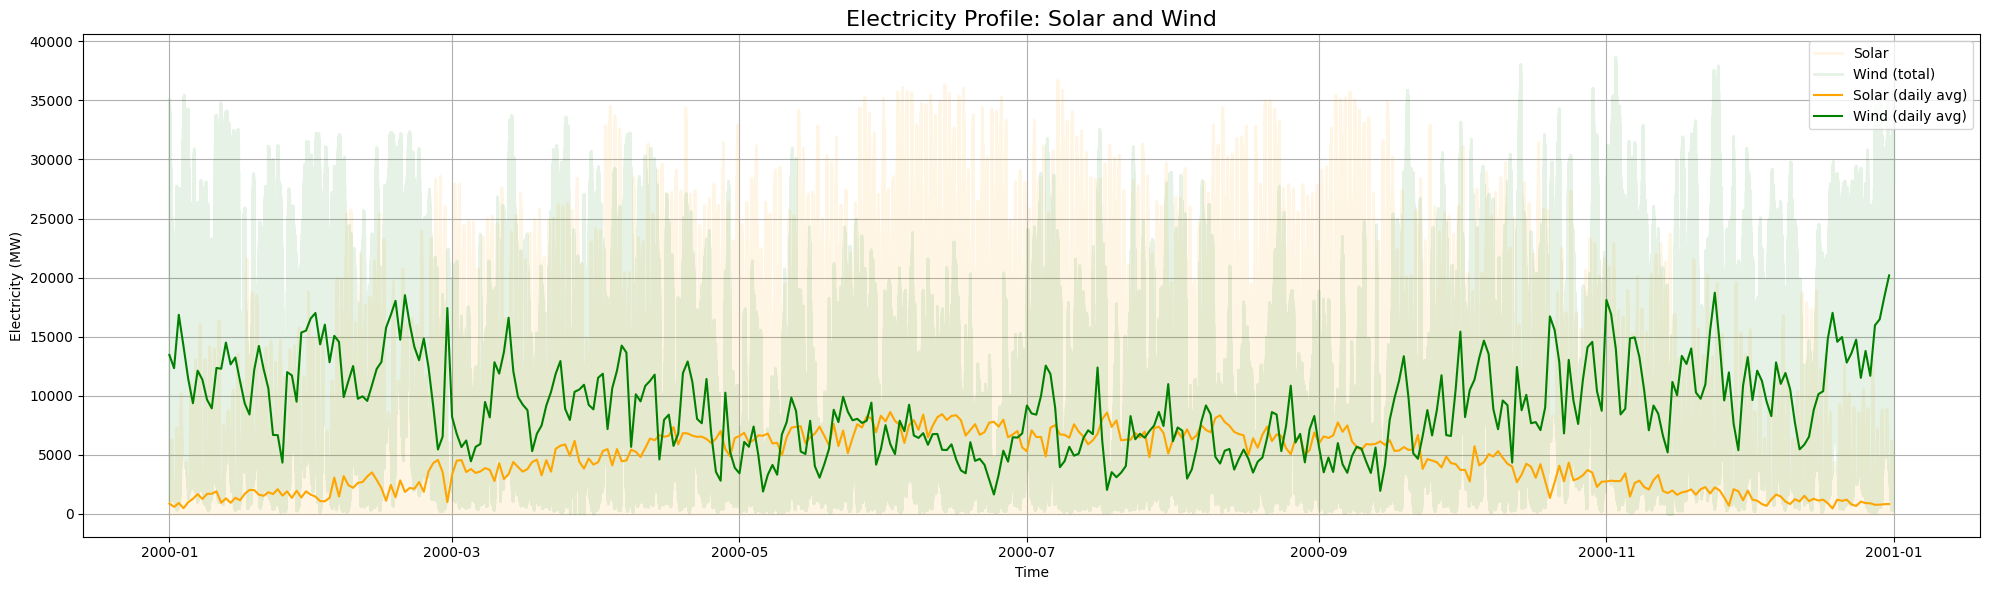

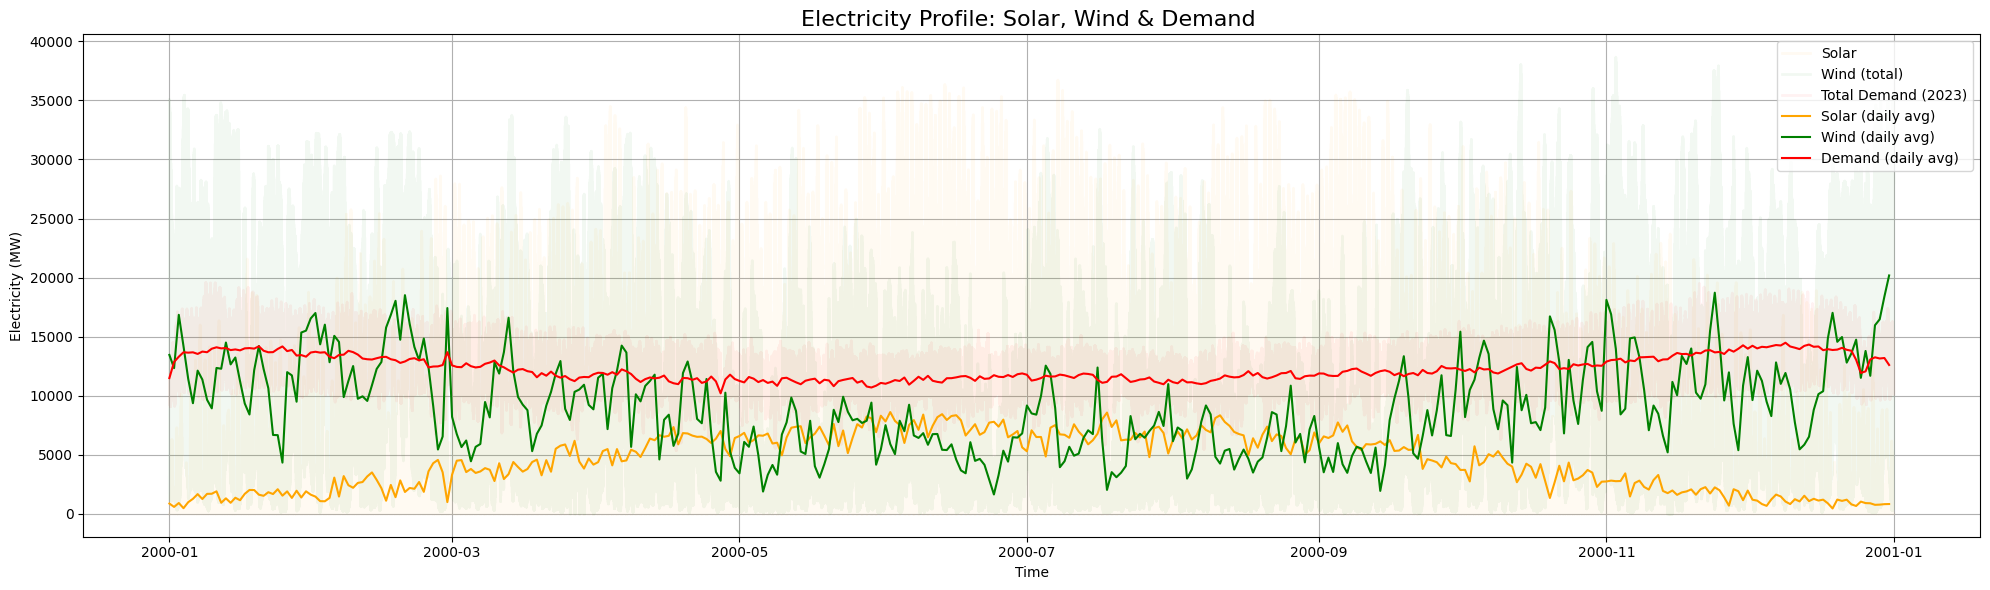

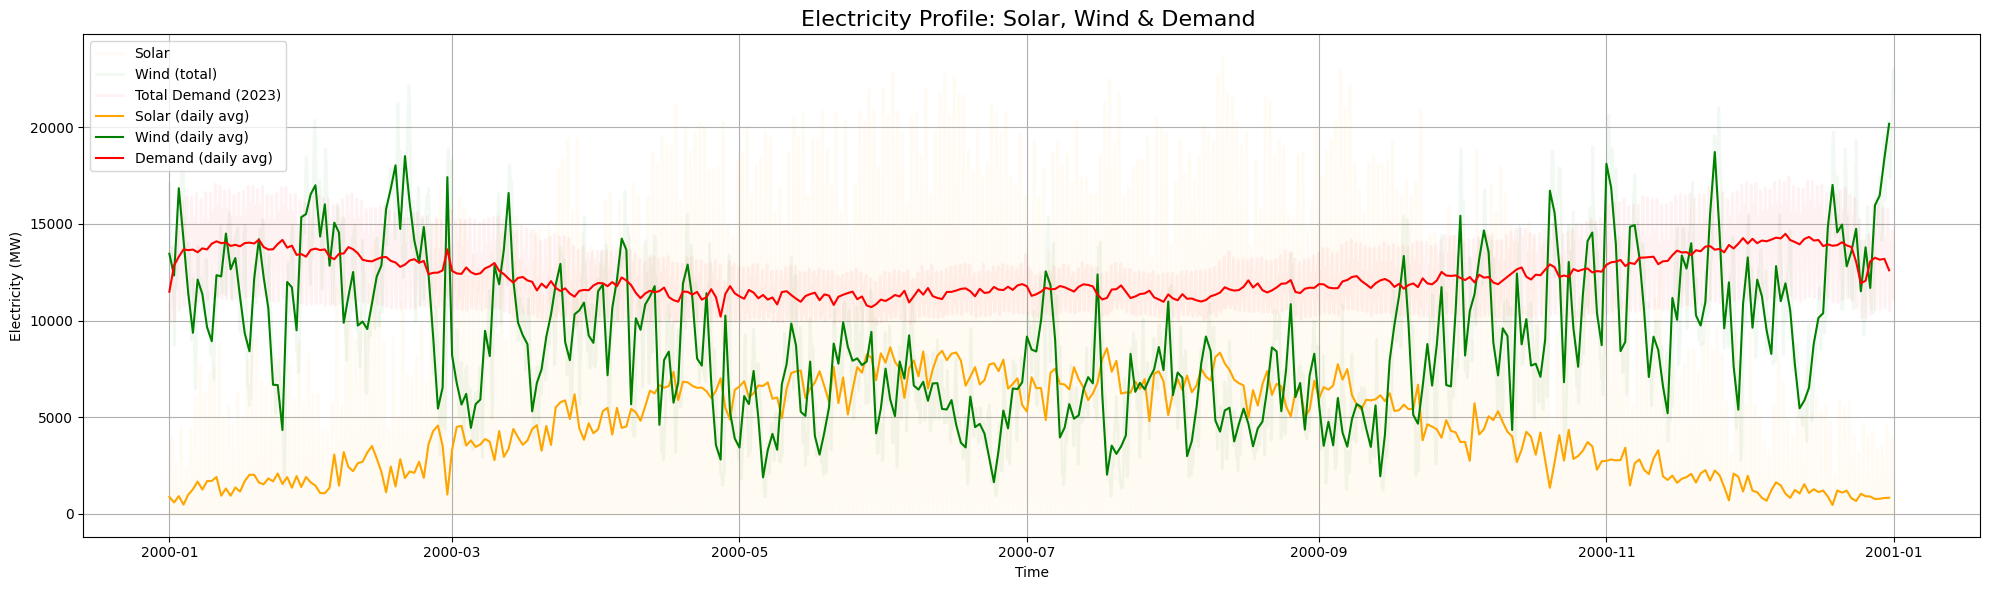

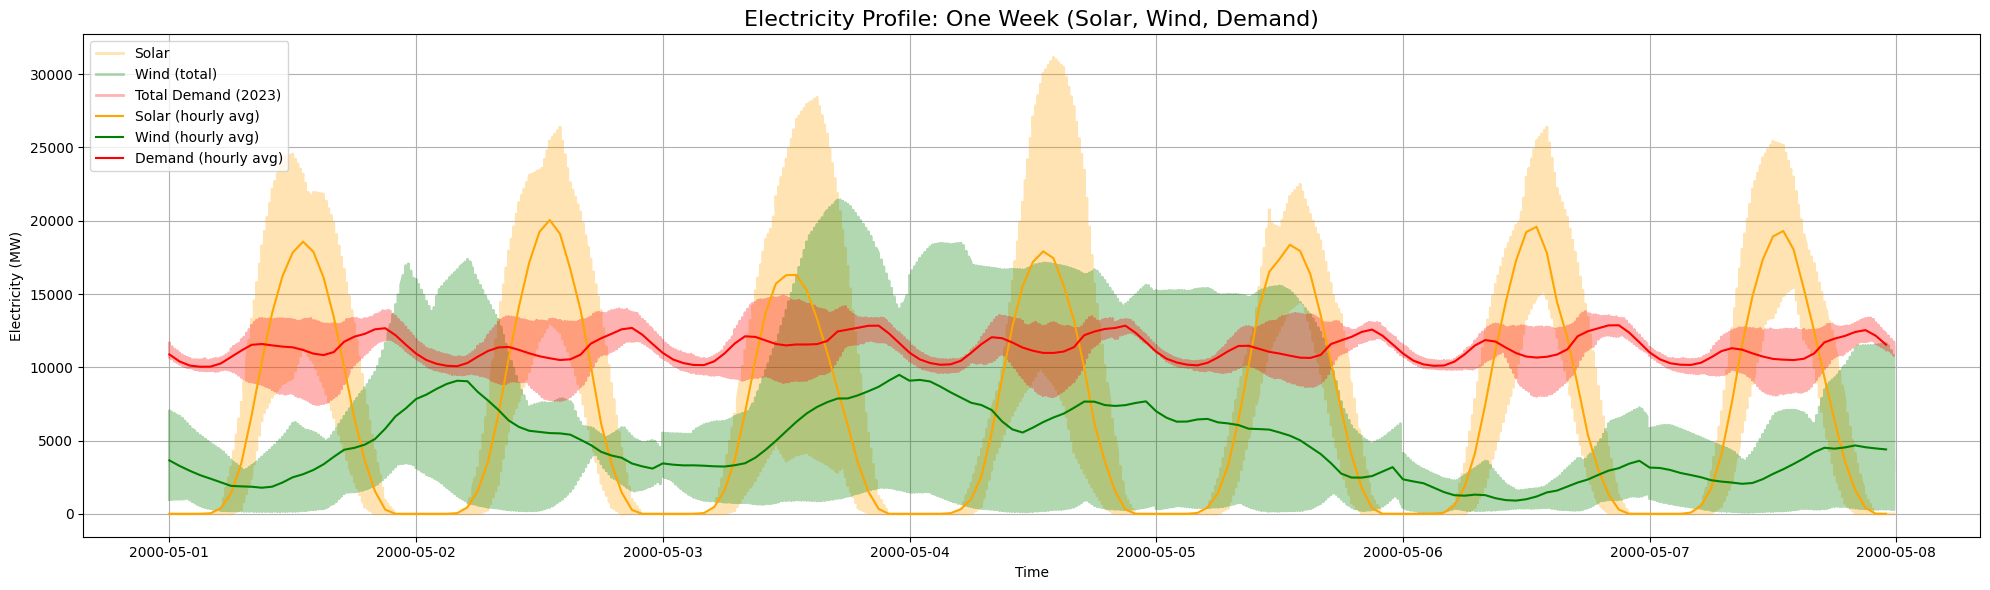

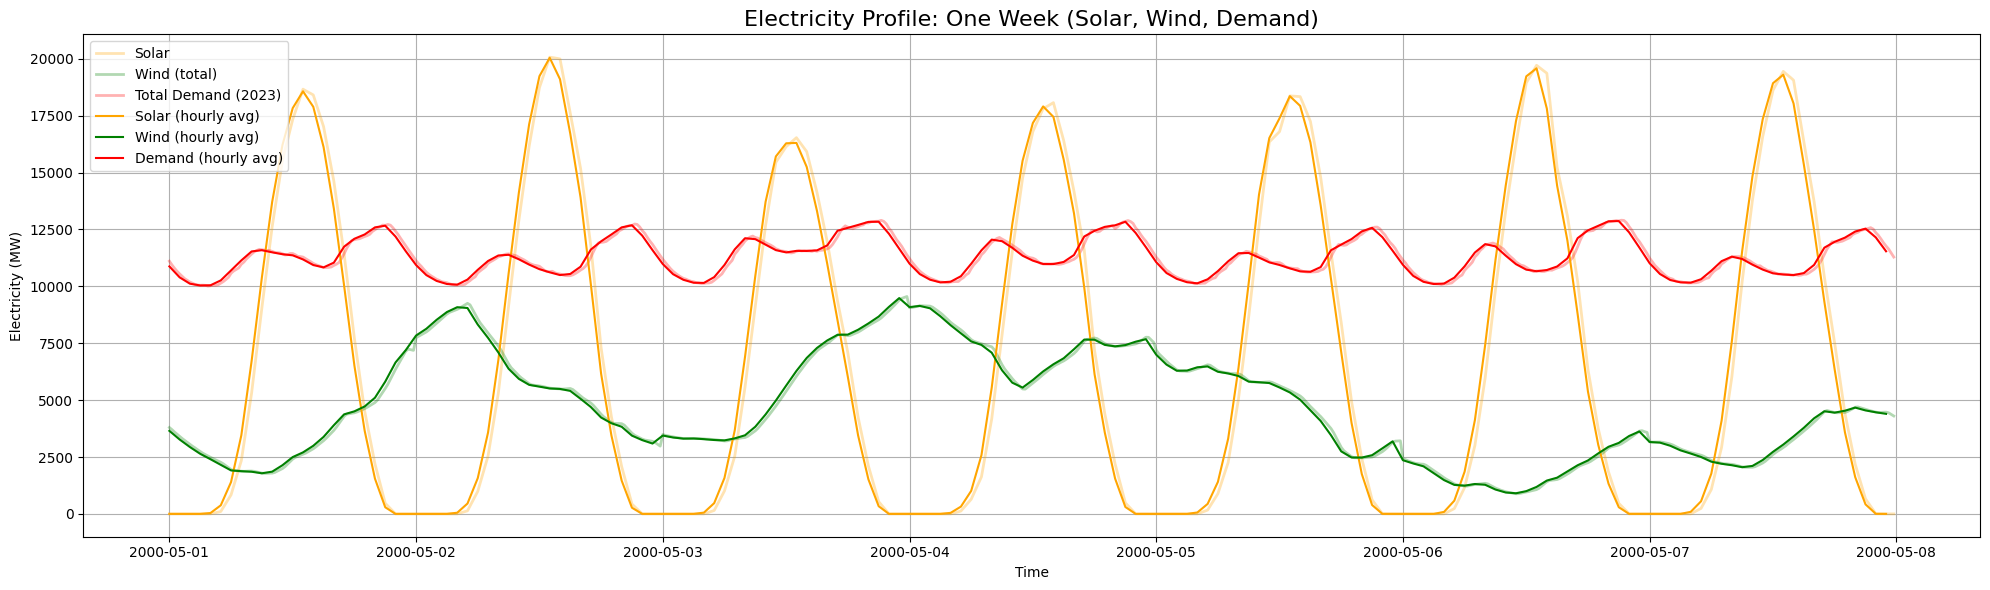

----- Original Energy Averages  -----
Average solar production   = 964.74 MW
Average wind production    = 1936.34 MW
Average total generation   = 2901.09 MW
Average electricity demand = 12300.67 MW
----- Energy Averages -----
Average solar production   = 4499.58 MW
Average wind production    = 9031.15 MW
Average total generation   = 13530.74 MW
Average electricity demand = 12300.67 MW

Average original electricity generation = 2901.09 MW
Average original electricity demand = 12300.67 MW
Production_inflation_factor = 4.66
generation factor: Production vs demand = 1.100
alternative energy = 0.00

Total intervals quater original= 175412
Total intervals quater _15min= 35136
Total intervals hour = 168
Total intervals load daily = 366


In [9]:
# Import dependencies new
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt

generation_factor = 1.1
alternative_Energy = 0

# Mount Google Drive
drive.mount('/content/drive')

# File paths
file_path_sup_2020 = '/content/drive/MyDrive/Batchelor_scriptie/entsoevoorspelling2020.csv'
file_path_sup_2021 = '/content/drive/MyDrive/Batchelor_scriptie/entsoevoorspelling2021.csv'
file_path_sup_2022 = '/content/drive/MyDrive/Batchelor_scriptie/entsoevoorspelling2022.csv'
file_path_sup_2023 = '/content/drive/MyDrive/Batchelor_scriptie/entsoevoorspelling2023.csv'
file_path_sup_2024 = '/content/drive/MyDrive/Batchelor_scriptie/entsoevoorspelling2024.csv'
file_path_load_2020 = '/content/drive/MyDrive/Batchelor_scriptie/Total_Load_2020_entsoe.csv'
file_path_load_2021 = '/content/drive/MyDrive/Batchelor_scriptie/Total_Load_2021_entsoe.csv'
file_path_load_2022 = '/content/drive/MyDrive/Batchelor_scriptie/Total_Load_2022_entsoe.csv'
file_path_load_2023 = '/content/drive/MyDrive/Batchelor_scriptie/Total_Load_2023_entsoe.csv'
file_path_load_2024 = '/content/drive/MyDrive/Batchelor_scriptie/Total_Load_2024_entsoe.csv'

# Load data
df_gen_2020 = pd.read_csv(file_path_sup_2020, na_values=['n/e'], quotechar='"')
df_gen_2021 = pd.read_csv(file_path_sup_2021, na_values=['n/e'], quotechar='"')
df_gen_2022 = pd.read_csv(file_path_sup_2022, na_values=['n/e'], quotechar='"')
df_gen_2023 = pd.read_csv(file_path_sup_2023, na_values=['n/e'], quotechar='"')
df_gen_2024 = pd.read_csv(file_path_sup_2024, na_values=['n/e'], quotechar='"')

df_load_2020 = pd.read_csv(file_path_load_2020, na_values=['n/e'], quotechar='"')
df_load_2021 = pd.read_csv(file_path_load_2021, na_values=['n/e'], quotechar='"')
df_load_2022 = pd.read_csv(file_path_load_2022, na_values=['n/e'], quotechar='"')
df_load_2023 = pd.read_csv(file_path_load_2023, na_values=['n/e'], quotechar='"')
df_load_2024 = pd.read_csv(file_path_load_2024, na_values=['n/e'], quotechar='"')

#gen_list =
load_list = (df_load_2020, df_load_2021, df_load_2022, df_load_2023, df_load_2024, df_gen_2023, df_gen_2024)


# Strip column names
for df in load_list:
    df.columns = df.columns.str.strip()


# Parse datetime for load data
for df in [df_gen_2020, df_gen_2021, df_gen_2022, df_gen_2023, df_gen_2024]:
    df[['start', 'end']] = df['MTU (CET/CEST)'].str.split(' - ', expand=True)
    df['start'] = pd.to_datetime(df['start'], format="%d.%m.%Y %H:%M")
    df.set_index('start', inplace=True)

# Parse datetime for load data
for df in [df_load_2020, df_load_2021, df_load_2022, df_load_2023, df_load_2024]:
    df[['start', 'end']] = df['Time (CET/CEST)'].str.split(' - ', expand=True)
    df['start'] = pd.to_datetime(df['start'], format="%d.%m.%Y %H:%M")
    df.set_index('start', inplace=True)

# Normalize all timestamps to the same reference year (e.g., 2000)
for df in [df_gen_2020, df_gen_2021, df_gen_2022, df_gen_2023, df_gen_2024]:
    df.index = df.index.map(lambda dt: dt.replace(year=2000))
for df in [df_load_2020, df_load_2021, df_load_2022, df_load_2023, df_load_2024]:
    df.index = df.index.map(lambda dt: dt.replace(year=2000))

# Drop unused columns
for df in [df_gen_2020, df_gen_2021, df_gen_2022, df_gen_2023, df_gen_2024]:
    df.drop(columns=['MTU (CET/CEST)', 'end'], inplace=True)
for df in [df_load_2020, df_load_2021, df_load_2022, df_load_2023, df_load_2024]:
    df.drop(columns=['Time (CET/CEST)', 'end'], inplace=True)

# Select relevant column
load_col = 'Actual Total Load [MW] - BZN|NL'
for df in [df_load_2020, df_load_2021, df_load_2022, df_load_2023, df_load_2024]:
    df[load_col] = pd.to_numeric(df[load_col], errors='coerce')

# Combine and average the load data
df_load = pd.concat([df_load_2020, df_load_2021, df_load_2022, df_load_2023, df_load_2024])
df_load_avg = df_load.groupby(df_load.index).mean()
df_load_avg.sort_index(inplace=True)


# Convert generation columns
solar_col = 'Generation - Solar [MW] Intraday / BZN|NL'
wind_off_col = 'Generation - Wind Offshore [MW] Intraday / BZN|NL'
wind_on_col = 'Generation - Wind Onshore [MW] Intraday / BZN|NL'

for df in [df_gen_2020, df_gen_2021, df_gen_2022, df_gen_2023, df_gen_2024]:
    df[solar_col] = pd.to_numeric(df[solar_col], errors='coerce')
    df[wind_off_col] = pd.to_numeric(df[wind_off_col], errors='coerce')
    df[wind_on_col] = pd.to_numeric(df[wind_on_col], errors='coerce')

df_gen = pd.concat([df_gen_2020, df_gen_2021, df_gen_2022, df_gen_2023, df_gen_2024])
# Prepare generation columns directly in df_gen
df_gen['solar'] = df_gen[solar_col].fillna(0)
df_gen['wind'] = df_gen[wind_off_col].fillna(0) + df_gen[wind_on_col].fillna(0)
df_gen['total_generation'] = df_gen['solar'] + df_gen['wind']

# Ensure demand column is numeric
df_load_avg[load_col] = pd.to_numeric(df_load_avg[load_col], errors='coerce')

org_avg_solar = df_gen['solar'].mean()
org_avg_wind = df_gen['wind'].mean()

# Calculate Production factor
avg_combined_original = df_gen['total_generation'].mean()
avg_demand_original = df_load[load_col].mean()


Production_inflation_factor = (avg_demand_original / avg_combined_original) * generation_factor

df_gen['solar'] = df_gen['solar'] * Production_inflation_factor
df_gen['wind'] = df_gen['wind'] * Production_inflation_factor
df_gen['altern'] = avg_demand_original * alternative_Energy
df_gen['total_generation'] = df_gen['solar'] + df_gen['wind'] + df_gen['altern']

# Calculate and print averages
avg_solar = df_gen['solar'].mean()
avg_wind = df_gen['wind'].mean()
avg_combined= df_gen['total_generation'].mean()
avg_demand = df_load[load_col].mean()

# Sort index before slicing
df_gen.sort_index(inplace=True)
df_load.sort_index(inplace=True)

# Slice to one week ---------------------------------------------------------------------------------------------------------
start_date = '2000-05-1'
end_date = '2000-05-7'
df_gen_week = df_gen.loc[start_date:end_date]
df_load_week = df_load.loc[start_date:end_date]
Weeknumber = pd.to_datetime(start_date).isocalendar().week
#  daily mean
df_gen_daily = df_gen.resample('D').mean()
df_load_daily = df_load.resample('D').mean()
df_gen_daily_week = df_gen_daily.loc[start_date:end_date]
df_load_daily_week = df_load_daily.loc[start_date:end_date]

#  15m mean
df_gen_15min = df_gen.resample('15T').mean()
df_load_15min = df_load.resample('15T').mean()

# Hourly mean for just that week
df_gen_hour_week = df_gen_week.resample('H').mean()
df_load_hour_week = df_load_week.resample('H').mean()

# 15m mean for just that week
df_gen_week_15min = df_gen_week.resample('15T').mean()
df_load_week_15min = df_load_week.resample('15T').mean()


# Merge for simulation
df_week_sim_15min = pd.merge(df_gen_week_15min[['total_generation']], df_load_week_15min[[load_col]], left_index=True, right_index=True)
df_week_sim = pd.merge(df_gen_week[['total_generation']], df_load_week[[load_col]], left_index=True, right_index=True)
df_sim = pd.merge(df_gen[['total_generation']], df_load[[load_col]], left_index=True, right_index=True)
df_sim_15min = pd.merge(df_gen_15min[['total_generation']], df_load_15min[[load_col]], left_index=True, right_index=True)

# Rename columns for simulator
df_week_sim_15min.rename(columns={'total_generation': 'total_electricity', load_col: 'load'}, inplace=True)
df_week_sim.rename(columns={'total_generation': 'total_electricity', load_col: 'load'}, inplace=True)
df_sim.rename(columns={'total_generation': 'total_electricity', load_col: 'load'}, inplace=True)
df_sim_15min.rename(columns={'total_generation': 'total_electricity', load_col: 'load'}, inplace=True)

# Plot full year solar & wind
plt.figure(figsize=(20, 6))
plt.plot(df_gen.index, df_gen['solar'], color='orange', linewidth=2, label='Solar', alpha=0.1)
plt.plot(df_gen.index, df_gen['wind'], color='green', linewidth=2, label='Wind (total)', alpha=0.1)

plt.plot(df_gen_daily.index, df_gen_daily['solar'], label='Solar (daily avg)', color='orange')
plt.plot(df_gen_daily.index, df_gen_daily['wind'], label='Wind (daily avg)', color='green')

plt.title('Electricity Profile: Solar and Wind', fontsize=16)
plt.xlabel('Time')
plt.ylabel('Electricity (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot full year including load
plt.figure(figsize=(20, 6))
plt.plot(df_gen.index, df_gen['solar'], color='orange', linewidth=2, label='Solar', alpha=0.05)
plt.plot(df_gen.index, df_gen['wind'], color='green', linewidth=2, label='Wind (total)', alpha=0.05)
plt.plot(df_load.index, df_load[load_col], color='red', linewidth=2, label='Total Demand (2023)', alpha=0.05)

plt.plot(df_gen_daily.index, df_gen_daily['solar'], label='Solar (daily avg)', color='orange')
plt.plot(df_gen_daily.index, df_gen_daily['wind'], label='Wind (daily avg)', color='green')
plt.plot(df_load_daily.index, df_load_daily[load_col], label='Demand (daily avg)', color='red')

plt.title('Electricity Profile: Solar, Wind & Demand ', fontsize=16)
plt.xlabel('Time')
plt.ylabel('Electricity (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Plot full year including load _15min
plt.figure(figsize=(20, 6))
plt.plot(df_gen_15min.index, df_gen_15min['solar'], color='orange', linewidth=2, label='Solar', alpha=0.05)
plt.plot(df_gen_15min.index, df_gen_15min['wind'], color='green', linewidth=2, label='Wind (total)', alpha=0.05)
plt.plot(df_load_15min.index, df_load_15min[load_col], color='red', linewidth=2, label='Total Demand (2023)', alpha=0.05)

plt.plot(df_gen_daily.index, df_gen_daily['solar'], label='Solar (daily avg)', color='orange')
plt.plot(df_gen_daily.index, df_gen_daily['wind'], label='Wind (daily avg)', color='green')
plt.plot(df_load_daily.index, df_load_daily[load_col], label='Demand (daily avg)', color='red')

plt.title('Electricity Profile: Solar, Wind & Demand ', fontsize=16)
plt.xlabel('Time')
plt.ylabel('Electricity (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot one week
plt.figure(figsize=(20, 6))
plt.plot(df_gen_week.index, df_gen_week['solar'], color='orange', linewidth=2, label='Solar', alpha=0.3)
plt.plot(df_gen_week.index, df_gen_week['wind'], color='green', linewidth=2, label='Wind (total)', alpha=0.3)
plt.plot(df_load_week.index, df_load_week[load_col], color='red', linewidth=2, label='Total Demand (2023)', alpha=0.3)
plt.plot(df_gen_hour_week.index, df_gen_hour_week['solar'], label='Solar (hourly avg)', color='orange')
plt.plot(df_gen_hour_week.index, df_gen_hour_week['wind'], label='Wind (hourly avg)', color='green')
plt.plot(df_load_hour_week.index, df_load_hour_week[load_col], label='Demand (hourly avg)', color='red')
plt.title('Electricity Profile: One Week (Solar, Wind, Demand)', fontsize=16)
plt.xlabel('Time')
plt.ylabel('Electricity (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot one week _15min
plt.figure(figsize=(20, 6))
plt.plot(df_gen_week_15min.index, df_gen_week_15min['solar'], color='orange', linewidth=2, label='Solar', alpha=0.3)
plt.plot(df_gen_week_15min.index, df_gen_week_15min['wind'], color='green', linewidth=2, label='Wind (total)', alpha=0.3)
plt.plot(df_load_week_15min.index, df_load_week_15min[load_col], color='red', linewidth=2, label='Total Demand (2023)', alpha=0.3)
plt.plot(df_gen_hour_week.index, df_gen_hour_week['solar'], label='Solar (hourly avg)', color='orange')
plt.plot(df_gen_hour_week.index, df_gen_hour_week['wind'], label='Wind (hourly avg)', color='green')
plt.plot(df_load_hour_week.index, df_load_hour_week[load_col], label='Demand (hourly avg)', color='red')
plt.title('Electricity Profile: One Week (Solar, Wind, Demand)', fontsize=16)
plt.xlabel('Time')
plt.ylabel('Electricity (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()






print("----- Original Energy Averages  -----")
print(f"Average solar production   = {org_avg_solar:.2f} MW")
print(f"Average wind production    = {org_avg_wind:.2f} MW")
print(f"Average total generation   = {avg_combined_original:.2f} MW")
print(f"Average electricity demand = {avg_demand_original:.2f} MW")

print("----- Energy Averages -----")
print(f"Average solar production   = {avg_solar:.2f} MW")
print(f"Average wind production    = {avg_wind:.2f} MW")
print(f"Average total generation   = {avg_combined:.2f} MW")
print(f"Average electricity demand = {avg_demand:.2f} MW")
print()


print(f"Average original electricity generation = {avg_combined_original:.2f} MW")
print(f"Average original electricity demand = {avg_demand_original:.2f} MW")
print(f"Production_inflation_factor = {Production_inflation_factor:.2f}")
print(f"generation factor: Production vs demand = {avg_combined / avg_demand:.3f}")
print(f"alternative energy = {alternative_Energy:.2f}")
print()

print(f"Total intervals quater original= {len(df_load[load_col])}")
print(f"Total intervals quater _15min= {len(df_load_15min[load_col])}")
print(f"Total intervals hour = {len(df_load_hour_week[load_col])}")
print(f"Total intervals load daily = {len(df_load_daily[load_col])}")




# **Nice data plot**

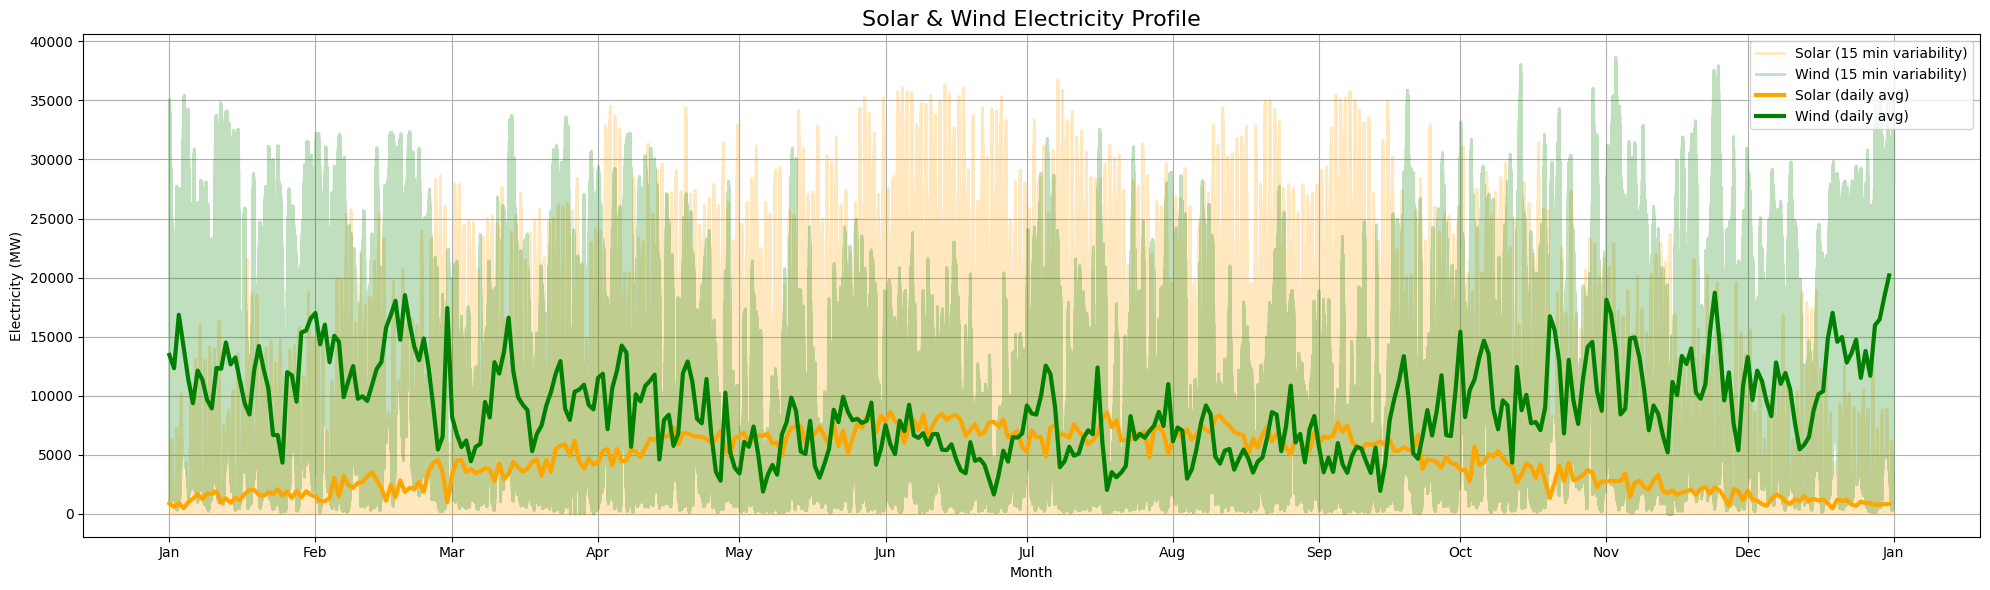

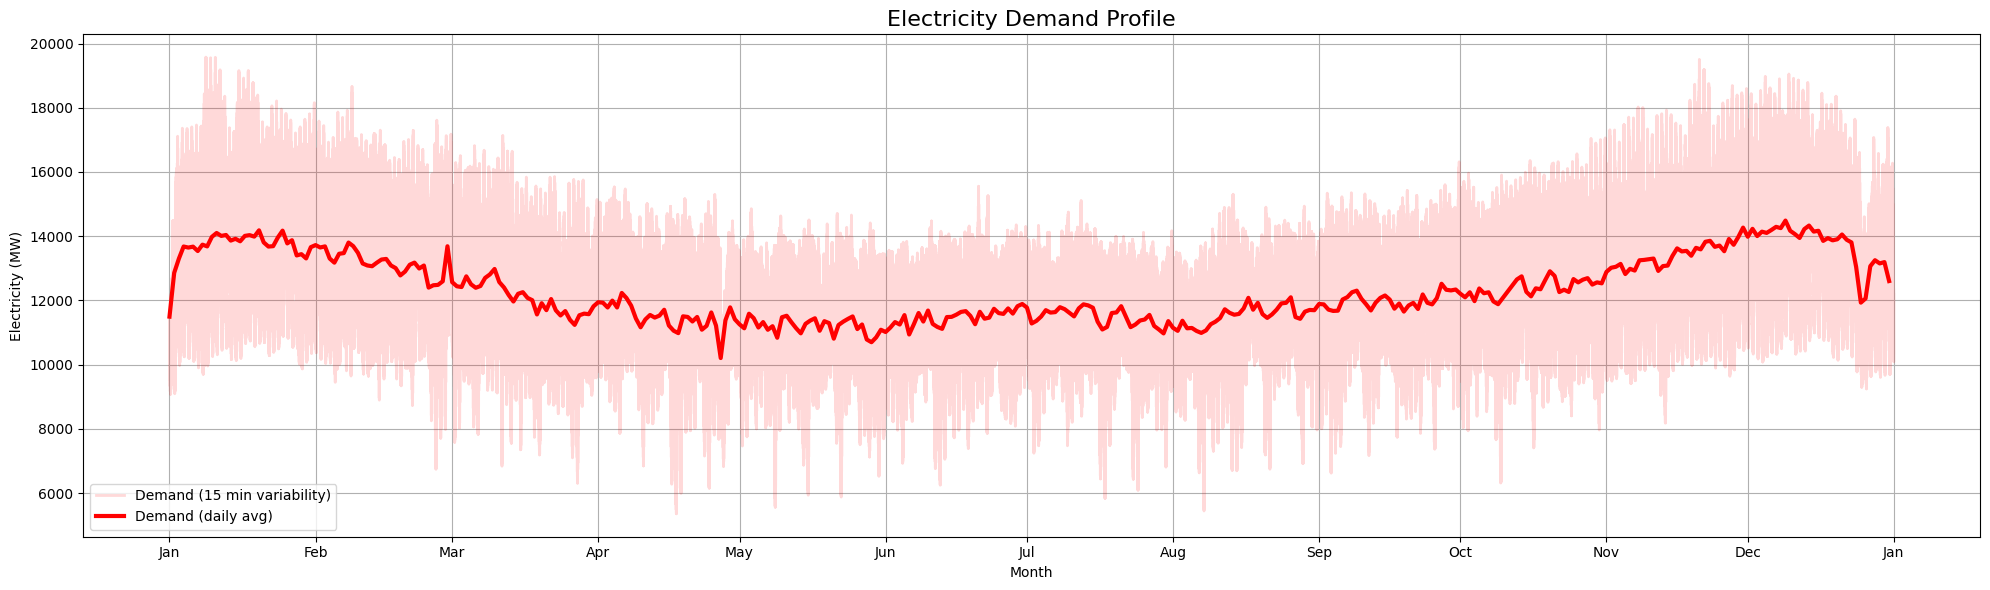

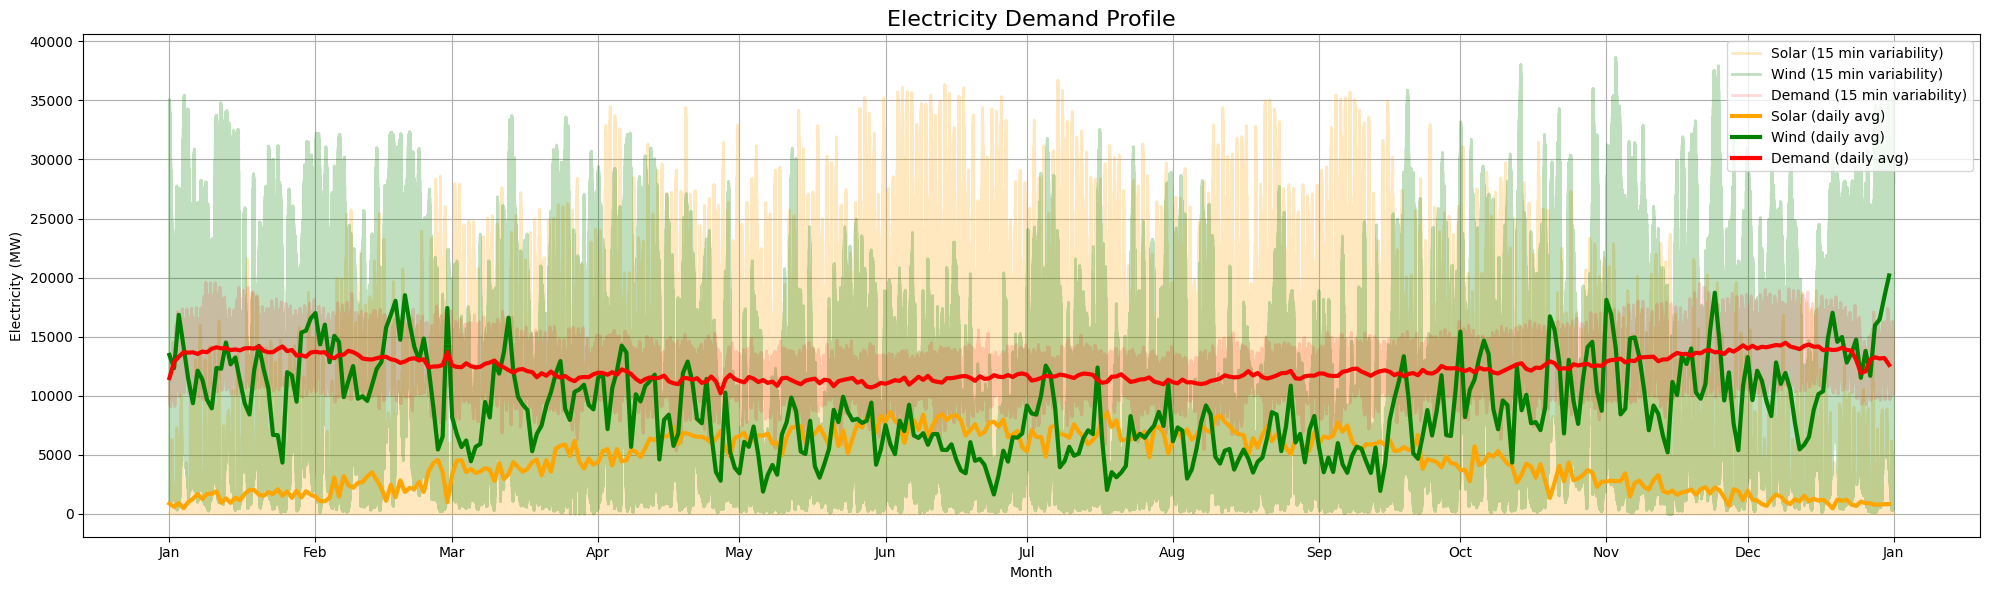

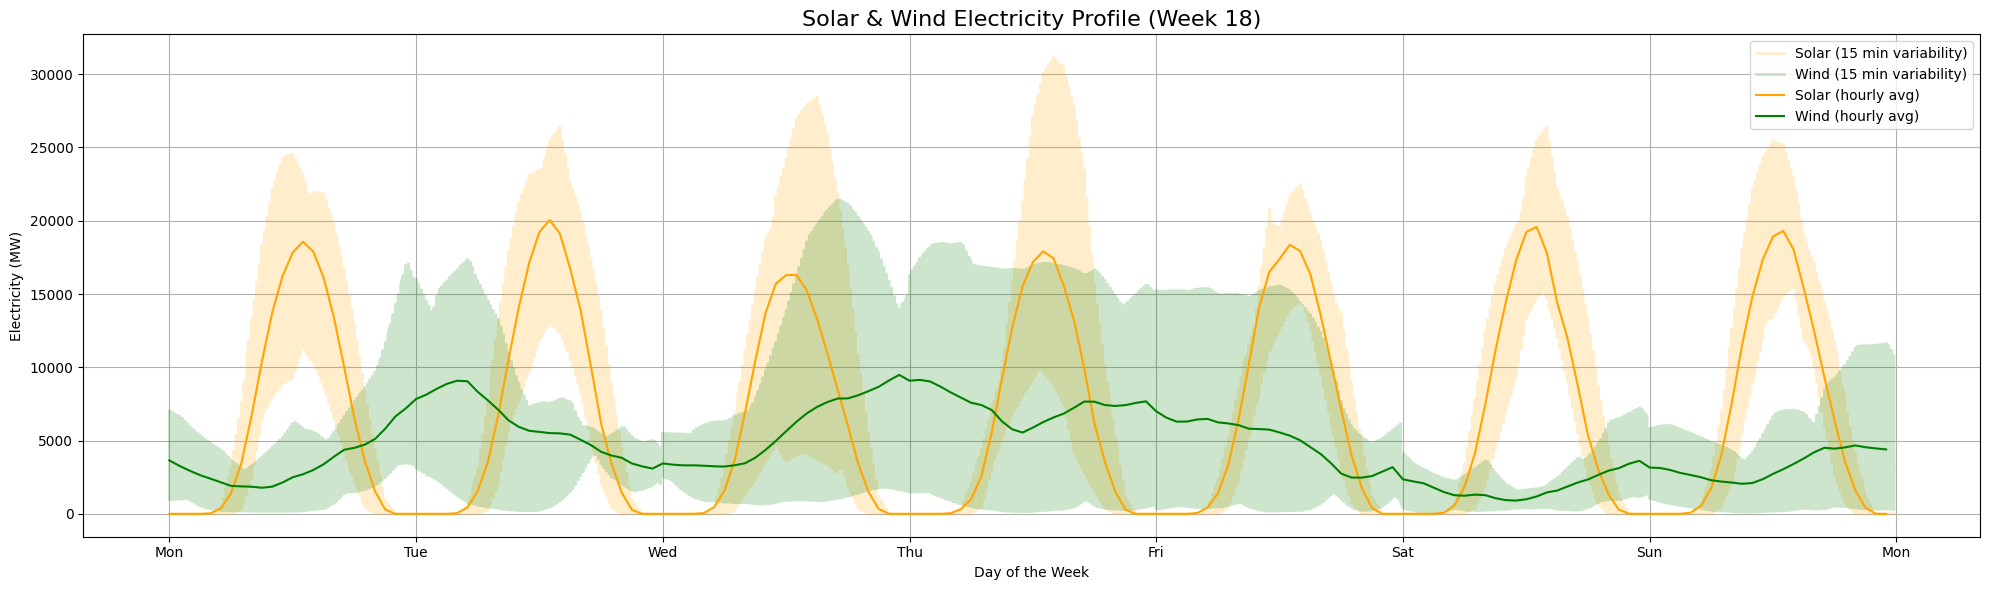

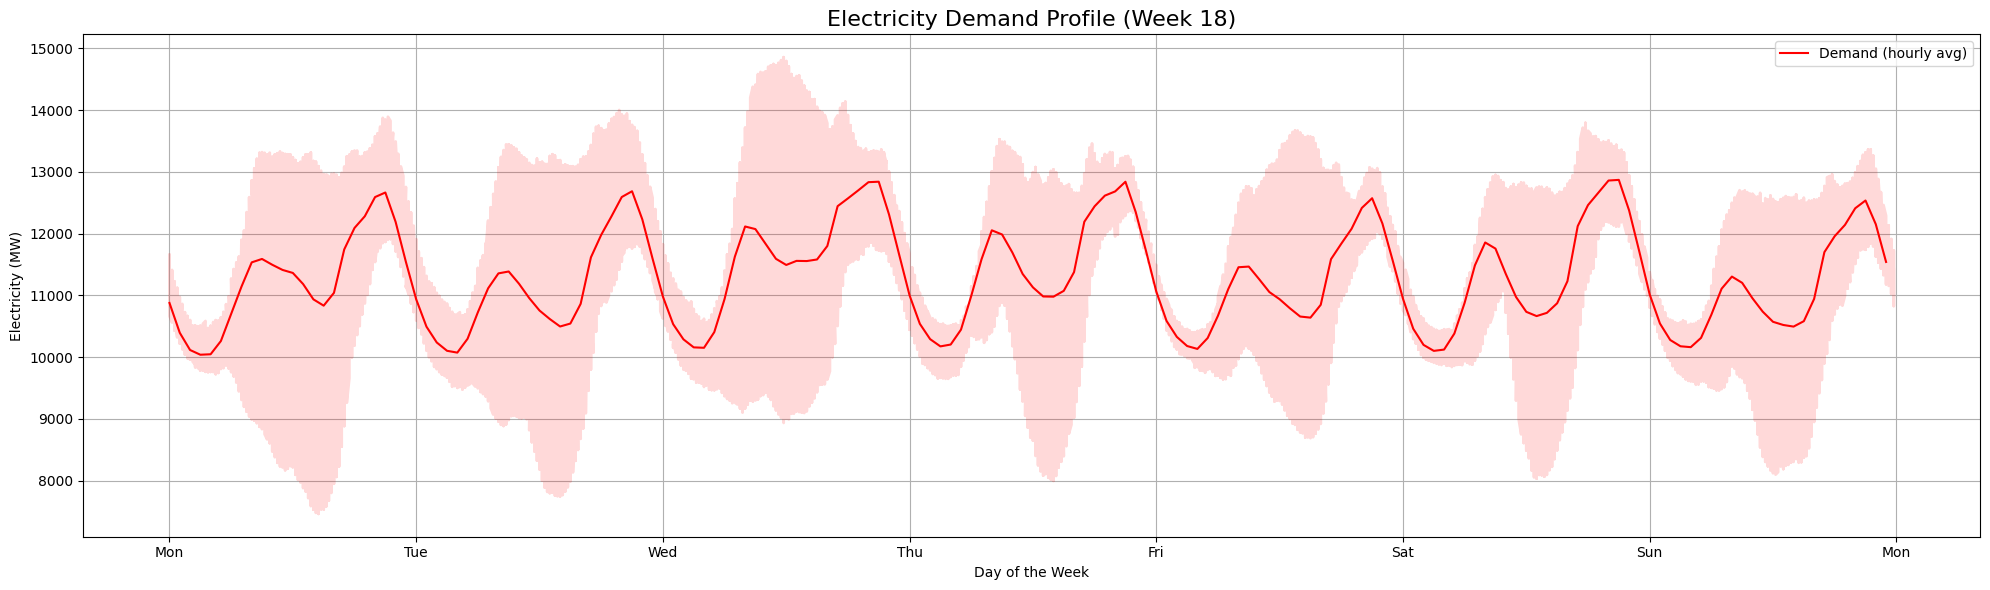

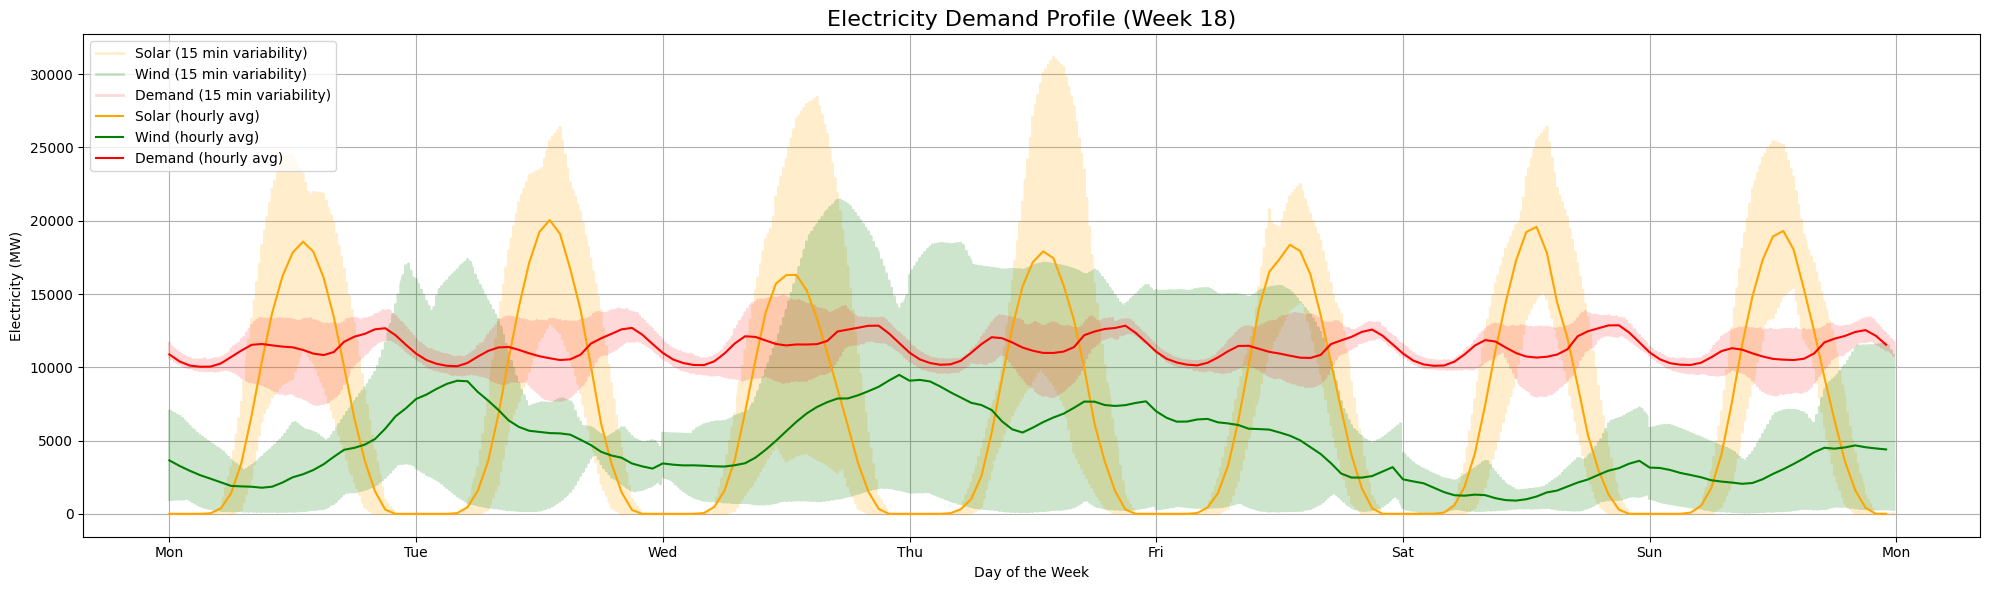

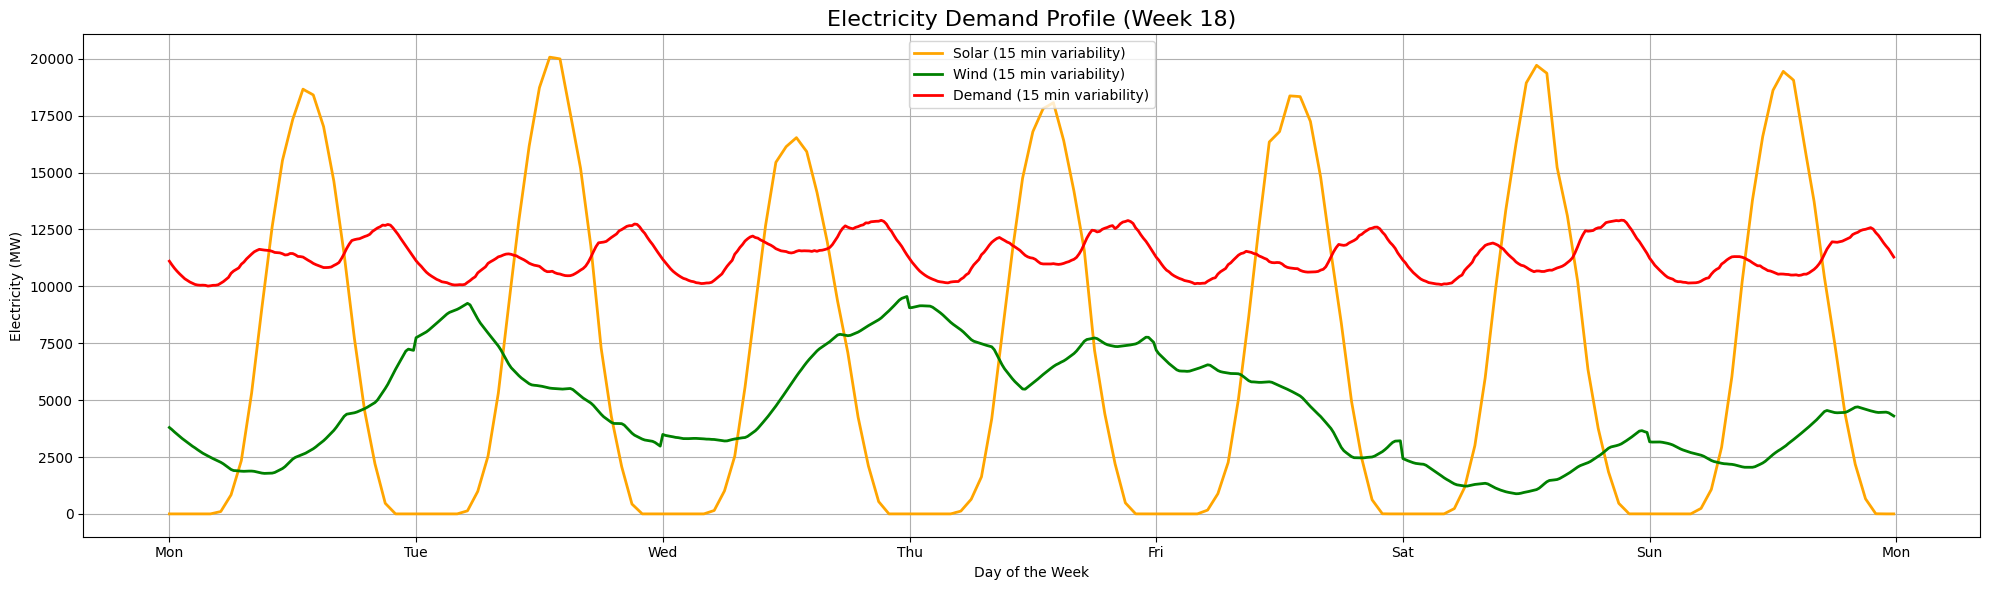

----- Energy Averages for the Selected Week -----
Average solar production   = 4499.58 MW
Average wind production    = 9031.15 MW
Average total generation   = 13530.74 MW
Average electricity demand = 12300.67 MW

Average original electricity generation = 2901.09 MW
Average original electricity demand = 12300.67 MW
Production_inflation_factor = 4.66
generation factor: Production vs demand = 1.100
alternative energy = 0.00



In [6]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D

# Plot full year production
plt.figure(figsize=(20, 6))
plt.plot(df_gen.index, df_gen['solar'], color='orange', linewidth=2, label='Solar (15 min variability)', alpha=0.25)
plt.plot(df_gen.index, df_gen['wind'], color='green', linewidth=2, label='Wind (15 min variability)', alpha=0.25)

plt.plot(df_gen_daily.index, df_gen_daily['solar'], label='Solar (daily avg)', color='orange', linewidth=3)
plt.plot(df_gen_daily.index, df_gen_daily['wind'], label='Wind (daily avg)', color='green', linewidth=3)

# Format x-axis to show month only (e.g., Jan, Feb)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # %b = short month name

plt.title('Solar & Wind Electricity Profile', fontsize=16)
#plt.xlabel('Time')
plt.xlabel('Month')
plt.ylabel('Electricity (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot full year demand
plt.figure(figsize=(20, 6))
plt.plot(df_load.index, df_load[load_col], color='red', linewidth=2, label='Demand (15 min variability)', alpha=0.15)
plt.plot(df_load_daily.index, df_load_daily[load_col], label='Demand (daily avg)', color='red', linewidth=3)

# Format x-axis to show month only (e.g., Jan, Feb)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # %b = short month name

plt.title('Electricity Demand Profile', fontsize=16)
#plt.xlabel('Time')
plt.xlabel('Month')
plt.ylabel('Electricity (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot full year all
plt.figure(figsize=(20, 6))
plt.plot(df_gen.index, df_gen['solar'], color='orange', linewidth=2, label='Solar (15 min variability)', alpha=0.25)
plt.plot(df_gen.index, df_gen['wind'], color='green', linewidth=2, label='Wind (15 min variability)', alpha=0.25)
plt.plot(df_load.index, df_load[load_col], color='red', linewidth=2, label='Demand (15 min variability)', alpha=0.15)

plt.plot(df_gen_daily.index, df_gen_daily['solar'], label='Solar (daily avg)', color='orange', linewidth=3)
plt.plot(df_gen_daily.index, df_gen_daily['wind'], label='Wind (daily avg)', color='green', linewidth=3)
plt.plot(df_load_daily.index, df_load_daily[load_col], label='Demand (daily avg)', color='red', linewidth=3)

# Format x-axis to show month only (e.g., Jan, Feb)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # %b = short month name

plt.title('Electricity Demand Profile', fontsize=16)
#plt.xlabel('Time')
plt.xlabel('Month')
plt.ylabel('Electricity (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



#Plot one week production
plt.figure(figsize=(20, 6))
plt.plot(df_gen_week.index, df_gen_week['solar'], color='orange', linewidth=2, alpha=0.2, label='Solar (15 min variability)')
plt.plot(df_gen_week.index, df_gen_week['wind'], color='green', linewidth=2,  alpha=0.2, label='Wind (15 min variability)')
plt.plot(df_gen_hour_week.index, df_gen_hour_week['solar'], label='Solar (hourly avg)', color='orange')
plt.plot(df_gen_hour_week.index, df_gen_hour_week['wind'], label='Wind (hourly avg)', color='green')

# Format x-axis to show abbreviated day names (Mon, Tue, ...)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%a'))  # %a = abbreviated weekday

plt.title(f'Solar & Wind Electricity Profile (Week {Weeknumber})', fontsize=16)
plt.xlabel('Day of the Week')
#plt.xlabel('Time')
plt.ylabel('Electricity (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot one week demand
plt.figure(figsize=(20, 6))
plt.plot(df_load_week.index, df_load_week[load_col], color='red', linewidth=2, alpha=0.15) # label='Total Demand (2023)',
plt.plot(df_load_hour_week.index, df_load_hour_week[load_col], label='Demand (hourly avg)', color='red')

# Format x-axis to show abbreviated day names (Mon, Tue, ...)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%a'))  # %a = abbreviated weekday

plt.title(f'Electricity Demand Profile (Week {Weeknumber})', fontsize=16)
plt.xlabel('Day of the Week')
#plt.xlabel('Time')
plt.ylabel('Electricity (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Plot one week all
plt.figure(figsize=(20, 6))
plt.plot(df_gen_week.index, df_gen_week['solar'], color='orange', linewidth=2, alpha=0.2, label='Solar (15 min variability)')
plt.plot(df_gen_week.index, df_gen_week['wind'], color='green', linewidth=2,  alpha=0.2, label='Wind (15 min variability)')
plt.plot(df_load_week.index, df_load_week[load_col], color='red', linewidth=2, alpha=0.15, label='Demand (15 min variability)')
plt.plot(df_gen_hour_week.index, df_gen_hour_week['solar'], label='Solar (hourly avg)', color='orange')
plt.plot(df_gen_hour_week.index, df_gen_hour_week['wind'], label='Wind (hourly avg)', color='green')
plt.plot(df_load_hour_week.index, df_load_hour_week[load_col], label='Demand (hourly avg)', color='red')

# Format x-axis to show abbreviated day names (Mon, Tue, ...)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%a'))  # %a = abbreviated weekday

# Custom legend handles
legend_elements = [
    Line2D([0], [0], color='orange', lw=2, label='Solar (hourly avg)'),
    Line2D([0], [0], color='orange', lw=2, alpha=0.2, label='Solar (15-min variability)'),
    Line2D([0], [0], color='green', lw=2, label='Wind (hourly avg)'),
    Line2D([0], [0], color='green', lw=2, alpha=0.2, label='Wind (15-min variability)'),
    Line2D([0], [0], color='red', lw=2, label='Demand (hourly avg)'),
    Line2D([0], [0], color='red', lw=2, alpha=0.15, label='Demand (15-min variability)'),
]

plt.legend(handles=legend_elements, loc='upper right')

plt.title(f'Electricity Demand Profile (Week {Weeknumber})', fontsize=16)
plt.xlabel('Day of the Week')
plt.ylabel('Electricity (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot one week all
plt.figure(figsize=(20, 6))
plt.plot(df_gen_week_15min.index, df_gen_week_15min['solar'], color='orange', linewidth=2, alpha=1, label='Solar (15 min variability)') #, label='Solar'
plt.plot(df_gen_week_15min.index, df_gen_week_15min['wind'], color='green', linewidth=2,  alpha=1, label='Wind (15 min variability)') #label='Wind (total)',,
plt.plot(df_load_week_15min.index, df_load_week_15min[load_col], color='red', linewidth=2, alpha=1, label='Demand (15 min variability)') # label='Total Demand (2023)',

# Format x-axis to show abbreviated day names (Mon, Tue, ...)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%a'))  # %a = abbreviated weekday

# Custom legend handles
legend_elements = [
    Line2D([0], [0], color='orange', lw=2, label='Solar (hourly avg)'),
    Line2D([0], [0], color='orange', lw=2, alpha=0.2, label='Solar (15-min variability)'),
    Line2D([0], [0], color='green', lw=2, label='Wind (hourly avg)'),
    Line2D([0], [0], color='green', lw=2, alpha=0.2, label='Wind (15-min variability)'),
    Line2D([0], [0], color='red', lw=2, label='Demand (hourly avg)'),
    Line2D([0], [0], color='red', lw=2, alpha=0.15, label='Demand (15-min variability)'),
]

plt.legend(handles=legend_elements, loc='upper right')

plt.title(f'Electricity Demand Profile (Week {Weeknumber})', fontsize=16)
plt.xlabel('Day of the Week')
#plt.xlabel('Time')
plt.ylabel('Electricity (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


print("----- Energy Averages for the Selected Week -----")
print(f"Average solar production   = {avg_solar:.2f} MW")
print(f"Average wind production    = {avg_wind:.2f} MW")
print(f"Average total generation   = {avg_combined:.2f} MW")
print(f"Average electricity demand = {avg_demand:.2f} MW")
print()
print(f"Average original electricity generation = {avg_combined_original:.2f} MW")
print(f"Average original electricity demand = {avg_demand_original:.2f} MW")
print(f"Production_inflation_factor = {Production_inflation_factor:.2f}")
print(f"generation factor: Production vs demand = {avg_combined / avg_demand:.3f}")
print(f"alternative energy = {alternative_Energy:.2f}")
print()

# **Test**

/tmp/ipython-input-17-3146782941.py:327: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


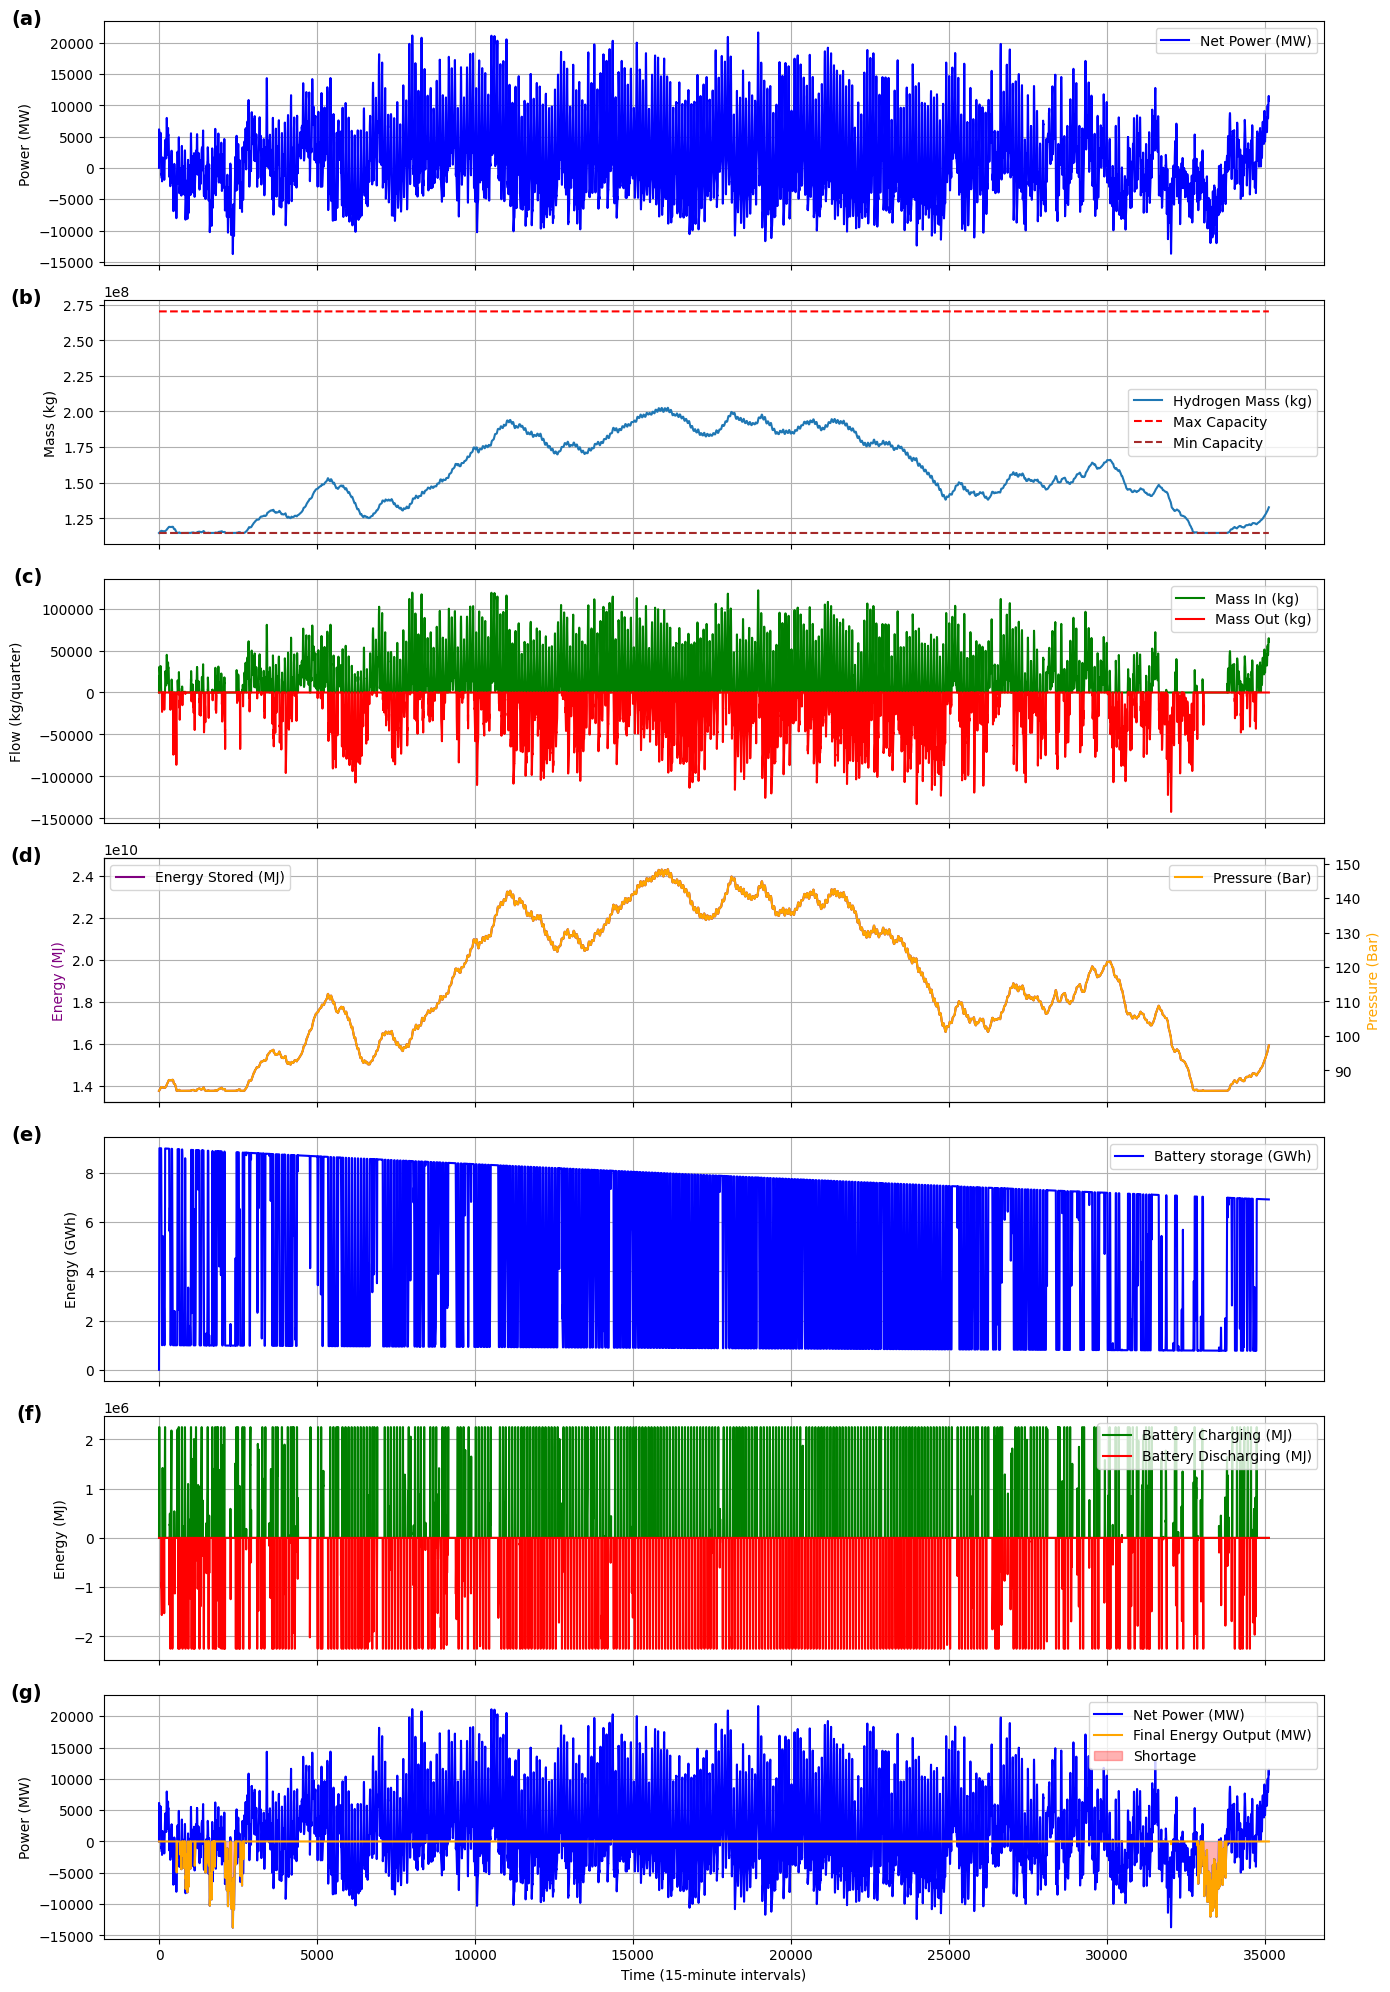

----- Batteries -----
Max battery storage = 6917.56 MWh
Min battery storage = 768.62 MWh

cycle count = 137.49

----- Cavern -----
Geological cavern volume = 20.0e6 m³
Maximal cavern pressure  = 198 bar
Minimal cavern pressure  = 84 bar
Cavern temperature = 323 K

----- Gas -----
Total gas in system = 270259 tons  (3305.04e6 m³) 
Working gas = 57.58% = 155604 tons   (1902.9e6 m³)
Cushion gas = 42.42% = 114655 tons

----- Energy -----
Total (all gas) energy in system  = 9005.64 GWh
Total (working gas) energy in system  = 5185.06 GWh
Hydrogen consumption efficiency = 0.7
Usable energy = 6303.95 GWh

----- Flow rate & Discharge -----
Max flow rate = 142182 kg/ 15min = 1.74e6 m³/ 15min
Max power delivery = 3316 MW
Discharge time full system = 274 hours

----- Reliability -----
Without hydrogen: 17341 intervals shortage → Reliability: 50.6461%
With hydrogen & batteries: 1682 intervals shortage → Reliability: 95.2129%
Total intervals = 35136
deficit: 1939.0 GWh   reliability: 95.2129%
defici

In [19]:
#test results
import numpy as np
import pandas as pd

"""
# --- Example run ---
hours = 672
quarters = hours*4
np.random.seed(42)  # for reproducibility

# Simulated net power signal: daily + weekly patterns + noise
net_power = -50000 + 150000 * np.sin(2 * np.pi * np.arange(quarters)/4 / 24) \
              + 100000 * np.sin(2 * np.pi * np.arange(quarters)/4 / (24 * 7)) \
              + np.random.normal(0, 50000, size=quarters)

# Create DataFrame for simulation input
hourlist = pd.DataFrame({
    'quarters': np.arange(quarters),
    'net_power': net_power,
    'total_electricity': 1,  # constant baseline for example
    'load': net_power        # or whatever your simulate_storage expects
})
"""

store_H0 = 20e6 #hystock
#store_H0 = 580000 # Clemens Dome
#store_H0 = 566000 # moss bluff
#store_H0 = 906000 # Spindletop Dome
#store_H0 = 70000 *3 # Teesside

store_B0 = 10e3*3600 #Battery storage

# Run the simulation
p0, var0, gdf0, df0, rg0, rt0, arr_H2, available_mass_H2, available_battery_storage = simulate_storage(df_sim_15min, store_H0, store_B0, "true")
#p0, var0, gdf0, df0, rg0, rt0, arr_H2, available_mass_H2, available_battery_storage = simulate_storage(df_week_sim_15min, store_H0, store_B0, "true")

#total_deficit = np.sum(var6) * 900
print(f"deficit: {round(abs(df0 / 3600 /1000),2)} GWh   reliability: {rt0}%")
print(f"deficit: {round(abs(gdf0 / 3600 /1000),2)} GWh   reliability: {rg0}%")



# **Results data in rows**

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D

# Define storage parameters
storage_H2 = (0, 5e6, 10e6, 15e6, 20e6, 25e6, 40e6, 80e6, 160e6, 320e6)# in m3
storage_B = (0, 1e3*3600, 10e3*3600, 100e3*3600)  # in MJ

# Use standard dicts for storage
p = {}
var = {}
gdf = {}
df_out = {}
rg = {}
rt = {}

# Simulate and store results
for h in storage_H2:
    for b in storage_B:
        try:
            result = simulate_storage(df_sim_15min, h, b, "false") #simulate_storage(df_week_sim, h, b, "false")
            if result is not None:
                p[h, b], var[h, b], gdf[h, b], df_out[h, b], rg[h, b], rt[h, b], arr_H2, H2_available, B_available = result
            else:
                print(f"[WARN] simulate_storage returned None for H={h}, B={b}")
        except Exception as e:
            print(f"[ERROR] simulate_storage failed for H={h}, B={b}: {e}")

# Summary statistics
print(f"\n-----")
print(f"Production_inflation_factor = {Production_inflation_factor:.2f}")
print(f"Generation factor: Production vs Demand = {avg_combined  / avg_demand:.3f}")
print(f"Additional alternative energy source = {alternative_Energy:.2f}")
print("-" * 80)
print(f"{'H2 (e6 m^3)':>10} {'Battery (GWh)':>15} {'Deficit (TWh)':>18} {'Reliability':>15}") #{'Storage':<12}
print("-" * 80)



h0 = storage_H2[0]
print(f" {0:>10} {0:>15} {round(abs(gdf[h0, 0] / 3600 / 1e6), 2):>18} {rg[h0, 0]:>15.2f}%")

# Print all storage configurations
for h in storage_H2:
    for b_idx, b in enumerate(storage_B):
        print(f" {h / 1e6:>10.0f} {b / 3600e3:>15.0f} {round(abs(df_out[h, b] / 3600 / 1e6), 2):>18} {rt[h, b]:>15.2f}%")
        if b_idx == len(storage_B) - 1:
            print()



[ERROR] simulate_storage failed for H=0, B=0: name 'simulate_storage' is not defined
[ERROR] simulate_storage failed for H=0, B=3600000.0: name 'simulate_storage' is not defined
[ERROR] simulate_storage failed for H=0, B=36000000.0: name 'simulate_storage' is not defined
[ERROR] simulate_storage failed for H=0, B=360000000.0: name 'simulate_storage' is not defined
[ERROR] simulate_storage failed for H=5000000.0, B=0: name 'simulate_storage' is not defined
[ERROR] simulate_storage failed for H=5000000.0, B=3600000.0: name 'simulate_storage' is not defined
[ERROR] simulate_storage failed for H=5000000.0, B=36000000.0: name 'simulate_storage' is not defined
[ERROR] simulate_storage failed for H=5000000.0, B=360000000.0: name 'simulate_storage' is not defined
[ERROR] simulate_storage failed for H=10000000.0, B=0: name 'simulate_storage' is not defined
[ERROR] simulate_storage failed for H=10000000.0, B=3600000.0: name 'simulate_storage' is not defined
[ERROR] simulate_storage failed for H=

NameError: name 'Production_inflation_factor' is not defined

# **Color map**

cmcrameri imported successfully.


(np.float64(-0.5), np.float64(99.5), np.float64(0.5), np.float64(-0.5))

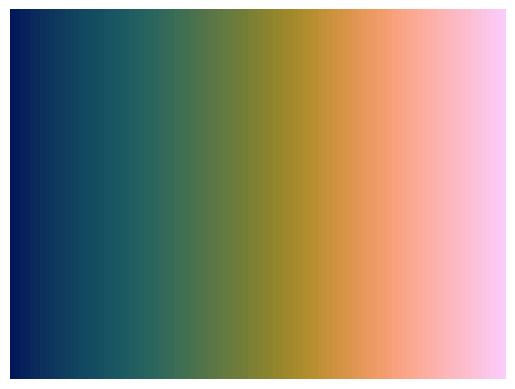

In [ ]:

# Install using pip as an alternative if conda fails
!pip install cmcrameri

# Verify that the installation was successful by attempting to import the module
try:
    from cmcrameri import cm
    print("cmcrameri imported successfully.")
except ModuleNotFoundError:
    print("Error: cmcrameri still not found after installation attempts.")
    # You might want to exit or raise an error here if the module is essential

import matplotlib.pyplot as plt
import numpy as np

# Create the data and plot
x = np.linspace(0, 100, 100)[None, :]
plt.imshow(x, aspect='auto', cmap=cm.batlow) # or any other colourmap
plt.axis('off')

# Display the plot if running in a non-interactive environment or script
# display(plt.gcf()) # Uncomment this line if you are in a non-interactive environment and need to explicitly display the plot

# **Overview plot**

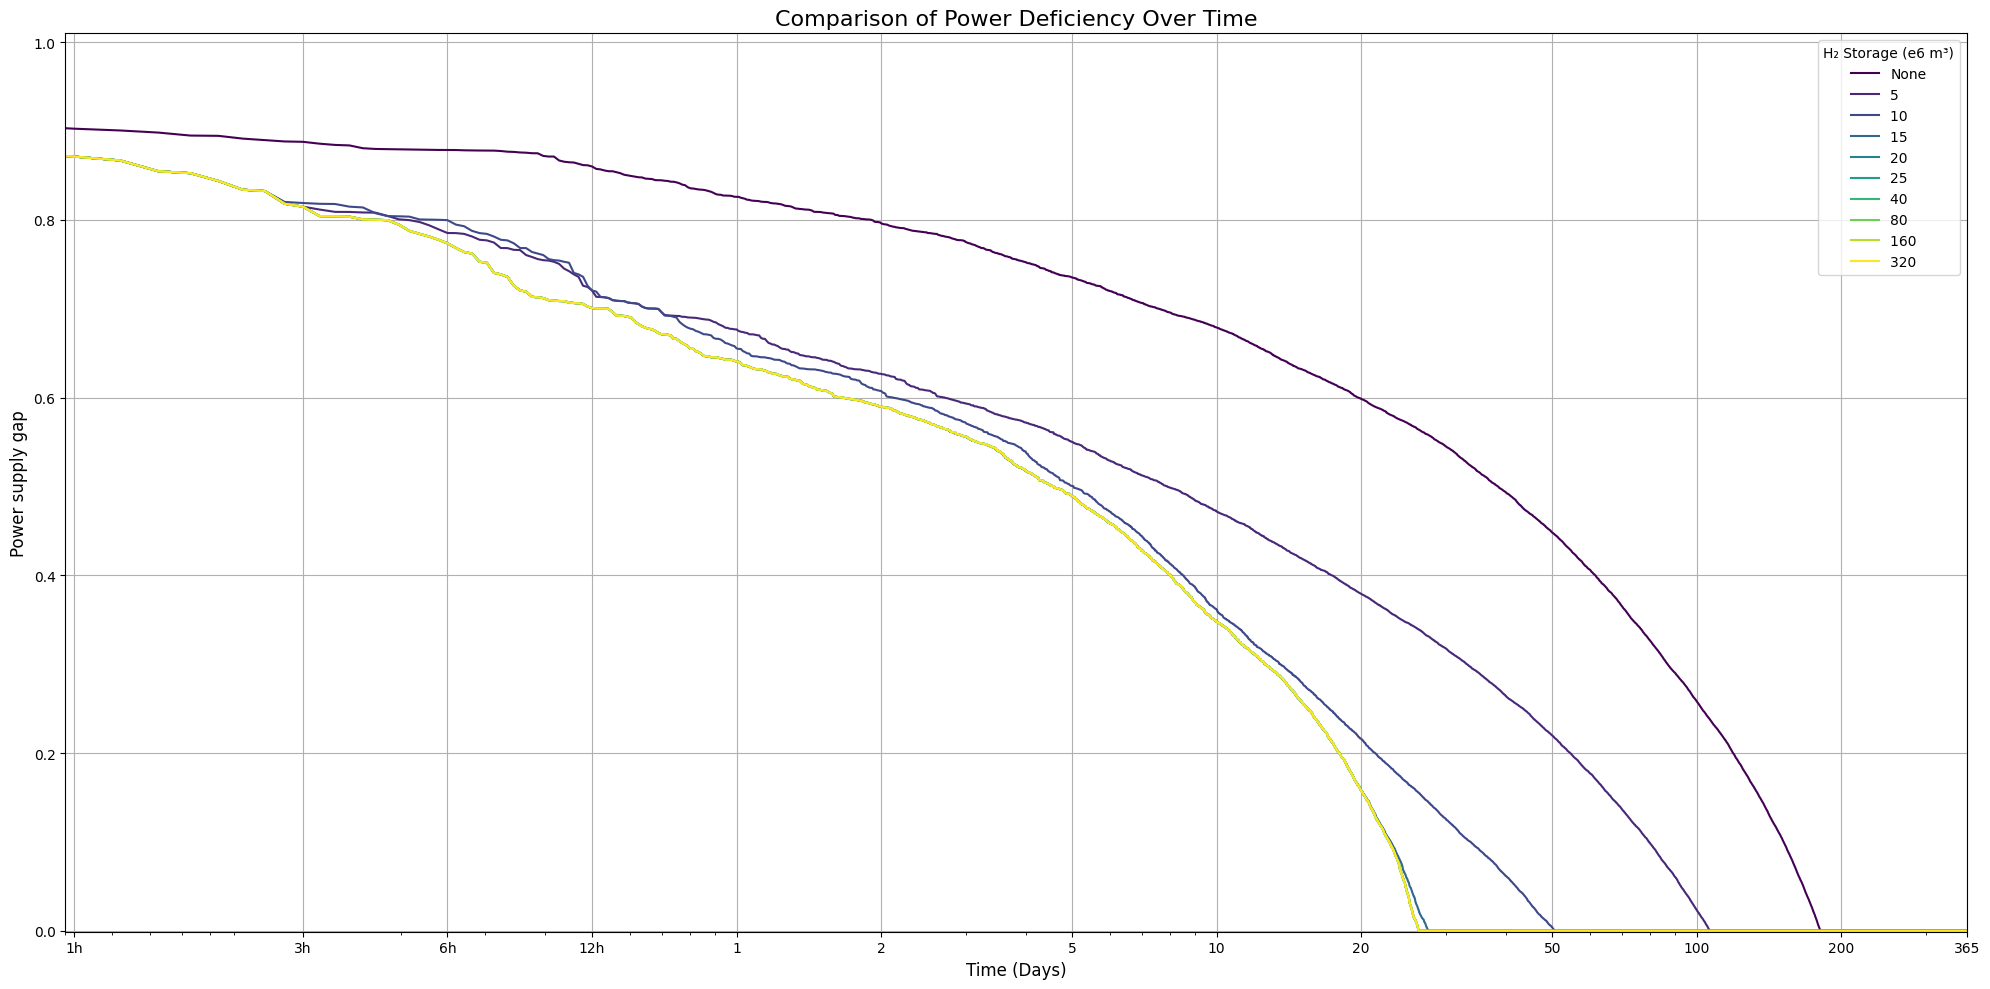

35136


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D  # Only needed for custom legends
from matplotlib.ticker import LogLocator, FixedLocator, LogFormatter


fig, ax = plt.subplots(figsize=(20, 10))
ax.set_title("Comparison of Power Deficiency Over Time", fontsize=16)

colors = [cm.viridis(i) for i in np.linspace(0, 1, len(storage_H2))]


handles_seen = {}

interval_minutes = 15
points_per_day = int(35136 / 365 ) #35000 # int(365 * 24 * 60 / (interval_minutes * 12 ))

for idx, h in enumerate(storage_H2):
    key = (h, 0)
    if key not in var:
        print(f"[WARN] Skipping var[{h}, 0] — no data")
        continue

    data = var[key]
    x_days = np.arange(len(data)) / points_per_day  # convert to days
    if h == 0:
        label = f"None"
    else:
        label = f"{int(h / 1e6)} "
    color = colors[idx]

    try:
        if isinstance(data, dict):
            for k, v in data.items():
                if isinstance(v, (list, tuple)) or hasattr(v, '__array__'):
                    x_days = np.arange(len(v)) / points_per_day
                    line, = ax.plot(x_days, v, label=f"{label} ({k})", color=color)
                    #line, = ax.plot(v, label=f"{label} ({k})", color=color, linestyle='-')
                    handles_seen[f"{label} ({k})"] = line
                    break
        else:
            #line, = ax.plot(data, label=label, color=color, linestyle='-')
            line, = ax.plot(x_days, data, label=label, color=color)
            handles_seen[label] = line
    except Exception as e:
        print(f"[ERROR] Plotting failed for var[{h}, 0]: {e}")

ax.set_xlabel("Time (Days)", fontsize=12)
ax.set_ylabel("Power supply gap", fontsize=12)
ax.set_xscale('log')
ax.set_xlim(left=0.04, right=365)
ax.set_ylim(-0.001, 1.01)

custom_days = [1/24, 0.125, 0.25, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 365]

ax.xaxis.set_major_locator(FixedLocator(custom_days))
ax.xaxis.set_major_formatter(LogFormatter(labelOnlyBase=False))
ax.set_xticklabels([
    "1h" if np.isclose(d, 1/24)
    else "3h" if np.isclose(d, 0.125)
    else "6h" if np.isclose(d, 0.25)
    else "12h" if np.isclose(d, 0.5)
    else f"{int(d)}"
    for d in custom_days
])

ax.grid(True, which='major')

# Add legend
ax.legend(
    handles=list(handles_seen.values()),
    labels=list(handles_seen.keys()),
    loc='upper right',
    fontsize=10,
    title= 'H₂ Storage (e6 m³)'
)

plt.tight_layout()
plt.show()
print(len(data))

# **Reliability and deficient plots**

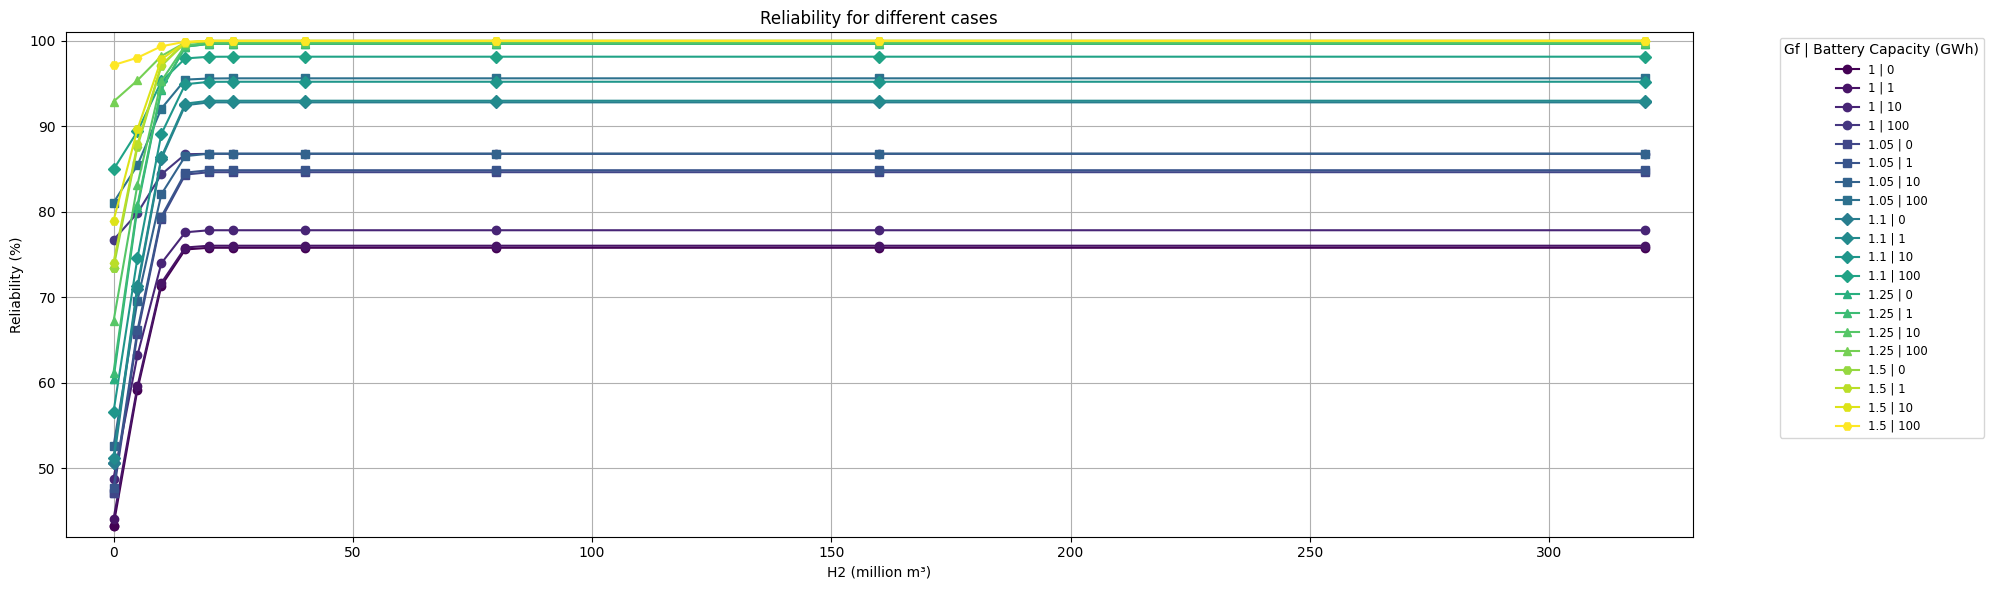

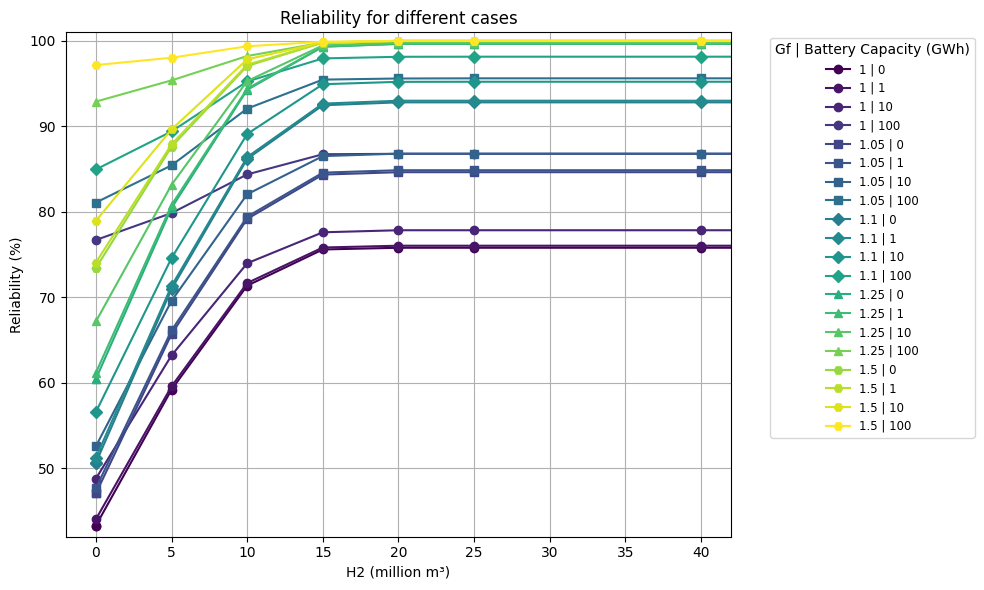

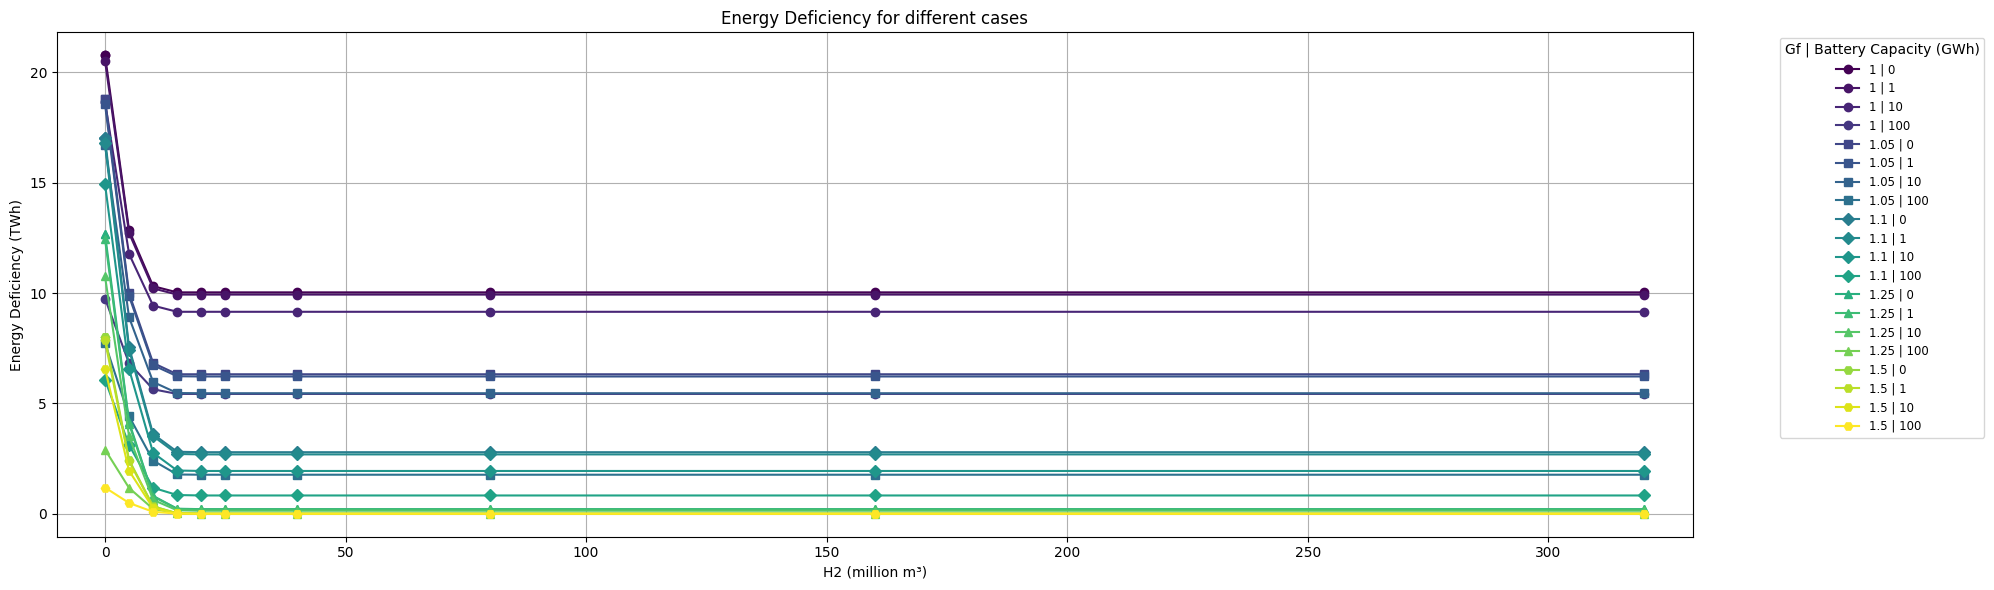

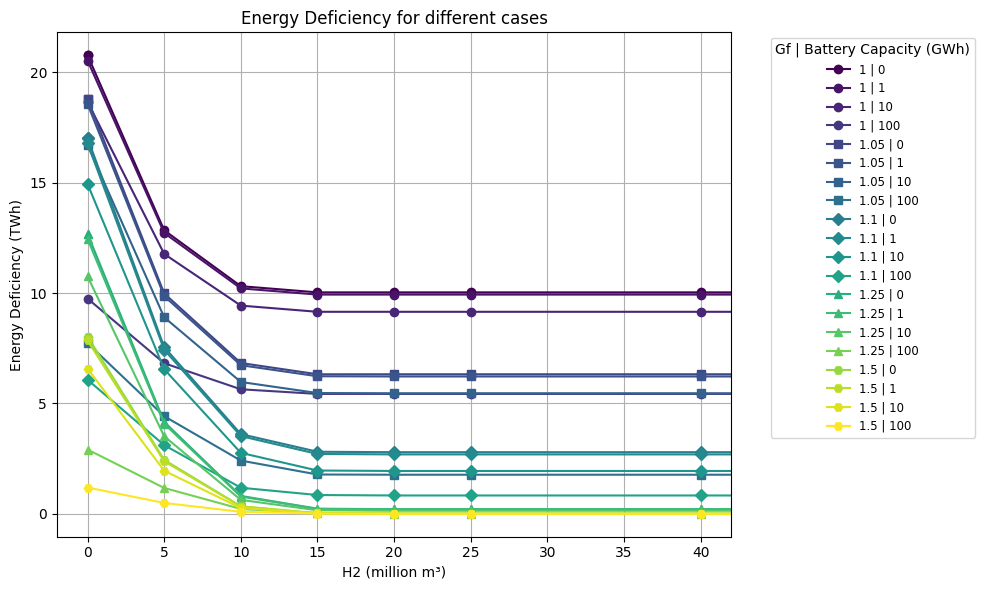

In [ ]:
# new
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import pandas as pd
import math



data1 = {
    "H2": [
        0, 0, 0, 0, 0,
        5, 5, 5, 5,
        10, 10, 10, 10,
        15, 15, 15, 15,
        20, 20, 20, 20,
        25, 25, 25, 25,
        40, 40, 40, 40,
        80, 80, 80, 80,
        160, 160, 160, 160,
        320, 320, 320, 320
    ],
    "Battery": [
        0, 0, 1, 10, 100,
        0, 1, 10, 100,
        0, 1, 10, 100,
        0, 1, 10, 100,
        0, 1, 10, 100,
        0, 1, 10, 100,
        0, 1, 10, 100,
        0, 1, 10, 100,
        0, 1, 10, 100,
        0, 1, 10, 100
    ],
    "Reliability": [
        43.31, 43.31, 44.05, 48.80, 76.71,
        59.21, 59.59, 63.21, 79.86,
        71.37, 71.68, 73.99, 84.38,
        75.60, 75.83, 77.61, 86.74,
        75.80, 76.04, 77.85, 86.79,
        75.80, 76.04, 77.85, 86.79,
        75.80, 76.04, 77.85, 86.79,
        75.80, 76.04, 77.85, 86.79,
        75.80, 76.04, 77.85, 86.79,
        75.80, 76.04, 77.85, 86.79
    ],
    "deficit_data": [
        20.77, 20.77, 20.53, 18.66, 9.75,
        12.84, 12.72, 11.77, 6.82,
        10.31, 10.21, 9.43, 5.64,
        10.03, 9.93, 9.15, 5.43,
        10.03, 9.93, 9.15, 5.43,
        10.03, 9.93, 9.15, 5.43,
        10.03, 9.93, 9.15, 5.43,
        10.03, 9.93, 9.15, 5.43,
        10.03, 9.93, 9.15, 5.43,
        10.03, 9.93, 9.15, 5.43
    ]
}

data5 = {
    "H2": [
        0, 0, 0, 0, 0,
        5, 5, 5, 5,
        10, 10, 10, 10,
        15, 15, 15, 15,
        20, 20, 20, 20,
        25, 25, 25, 25,
        40, 40, 40, 40,
        80, 80, 80, 80,
        160, 160, 160, 160,
        320, 320, 320, 320
    ],
    "Battery": [
        0, 0, 1, 10, 100,
        0, 1, 10, 100,
        0, 1, 10, 100,
        0, 1, 10, 100,
        0, 1, 10, 100,
        0, 1, 10, 100,
        0, 1, 10, 100,
        0, 1, 10, 100,
        0, 1, 10, 100,
        0, 1, 10, 100
    ],
    "Reliability": [
        52.30, 52.30, 53.00, 58.56, 86.58,
        73.50, 73.92, 77.18, 90.70,
        89.85, 90.00, 91.56, 95.95,
        96.81, 97.11, 97.69, 98.36,
        97.26, 97.55, 98.11, 98.53,
        97.27, 97.56, 98.12, 98.55,
        97.27, 97.56, 98.12, 98.55,
        97.27, 97.56, 98.12, 98.55,
        97.27, 97.56, 98.12, 98.55,
        97.27, 97.56, 98.12, 98.55
    ],
    "deficit_data": [
        16.19, 16.19, 15.95, 14.13, 5.37,
        6.57, 6.46, 5.62, 2.58,
        2.27, 2.21, 1.74, 0.98,
        1.09, 0.99, 0.84, 0.69,
        1.05, 0.95, 0.8, 0.67,
        1.05, 0.95, 0.8, 0.67,
        1.05, 0.95, 0.8, 0.67,
        1.05, 0.95, 0.8, 0.67,
        1.05, 0.95, 0.8, 0.67,
        1.05, 0.95, 0.8, 0.67
    ]
}


data2 = {
    "H2": [
        0, 0, 0, 0, 0,
        5, 5, 5, 5,
        10, 10, 10, 10,
        15, 15, 15, 15,
        20, 20, 20, 20,
        25, 25, 25, 25,
        40, 40, 40, 40,
        80, 80, 80, 80,
        160, 160, 160, 160,
        320, 320, 320, 320
    ],
    "Battery": [
        0, 0, 1, 10, 100,
        0, 1, 10, 100,
        0, 1, 10, 100,
        0, 1, 10, 100,
        0, 1, 10, 100,
        0, 1, 10, 100,
        0, 1, 10, 100,
        0, 1, 10, 100,
        0, 1, 10, 100,
        0, 1, 10, 100
    ],
    "Reliability": [
        60.47, 60.47, 61.19, 67.18, 92.90,
        80.46, 80.81, 83.17, 95.38,
        94.28, 94.40, 95.30, 98.23,
        99.32, 99.33, 99.47, 99.80,
        99.65, 99.66, 99.78, 99.94,
        99.65, 99.66, 99.78, 99.94,
        99.65, 99.66, 99.78, 99.94,
        99.65, 99.66, 99.78, 99.94,
        99.65, 99.66, 99.78, 99.94,
        99.65, 99.66, 99.78, 99.94
    ],
    "deficit_data": [
        12.68, 12.68, 12.45, 10.75, 2.91,
        4.16, 4.08, 3.51, 1.17,
        0.81, 0.78, 0.63, 0.22,
        0.23, 0.22, 0.16, 0.03,
        0.21, 0.2, 0.14, 0.01,
        0.21, 0.2, 0.14, 0.01,
        0.21, 0.2, 0.14, 0.01,
        0.21, 0.2, 0.14, 0.01,
        0.21, 0.2, 0.14, 0.01,
        0.21, 0.2, 0.14, 0.01
    ]
}


data3 = {
    "H2": [
        0, 0, 0, 0, 0,
        5, 5, 5, 5,
        10, 10, 10, 10,
        15, 15, 15, 15,
        20, 20, 20, 20,
        25, 25, 25, 25,
        40, 40, 40, 40,
        80, 80, 80, 80,
        160, 160, 160, 160,
        320, 320, 320, 320
    ],
    "Battery": [
        0, 0, 1, 10, 100,
        0, 1, 10, 100,
        0, 1, 10, 100,
        0, 1, 10, 100,
        0, 1, 10, 100,
        0, 1, 10, 100,
        0, 1, 10, 100,
        0, 1, 10, 100,
        0, 1, 10, 100,
        0, 1, 10, 100
    ],
    "Reliability": [
        73.43, 73.43, 74.07, 78.96, 97.17,
        87.63, 87.90, 89.65, 98.03,
        97.07, 97.21, 97.84, 99.37,
        99.80, 99.80, 99.83, 99.90,
        100.00, 100.00, 100.00, 100.00,
        100.00, 100.00, 100.00, 100.00,
        100.00, 100.00, 100.00, 100.00,
        100.00, 100.00, 100.00, 100.00,
        100.00, 100.00, 100.00, 100.00,
        100.00, 100.00, 100.00, 100.00
    ],
    "deficit_data": [
        8.03, 8.03, 7.85, 6.58, 1.19,
        2.44, 2.38, 1.95, 0.49,
        0.34, 0.33, 0.26, 0.09,
        0.02, 0.02, 0.02, 0.01,
        0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0,
        0.0, 0.0, 0.0, 0.0
    ]
}

data4 = {
    "H2": [
        0, 0, 0, 0, 0,
        5, 5, 5, 5,
        10, 10, 10, 10,
        15, 15, 15, 15,
        20, 20, 20, 20,
        25, 25, 25, 25,
        40, 40, 40, 40,
        80, 80, 80, 80,
        160, 160, 160, 160,
        320, 320, 320, 320
    ],
    "Battery": [
        0, 0, 1, 10, 100,
        0, 1, 10, 100,
        0, 1, 10, 100,
        0, 1, 10, 100,
        0, 1, 10, 100,
        0, 1, 10, 100,
        0, 1, 10, 100,
        0, 1, 10, 100,
        0, 1, 10, 100,
        0, 1, 10, 100
    ],
    "deficit_data": [
        5.33, 5.33, 5.20, 4.23, 0.50,
        1.49, 1.45, 1.13, 0.20,
        0.20, 0.19, 0.14, 0.04,
        0.01, 0.01, 0.01, 0.00,
        0.00, 0.00, 0.00, 0.00,
        0.00, 0.00, 0.00, 0.00,
        0.00, 0.00, 0.00, 0.00,
        0.00, 0.00, 0.00, 0.00,
        0.00, 0.00, 0.00, 0.00,
        0.00, 0.00, 0.00, 0.00
    ],
    "Reliability": [
        81.32, 81.32, 81.79, 85.34, 98.77,
        91.91, 92.06, 93.45, 99.17,
        98.34, 98.40, 98.83, 99.72,
        99.88, 99.88, 99.91, 99.96,
        100.00, 100.00, 100.00, 100.00,
        100.00, 100.00, 100.00, 100.00,
        100.00, 100.00, 100.00, 100.00,
        100.00, 100.00, 100.00, 100.00,
        100.00, 100.00, 100.00, 100.00,
        100.00, 100.00, 100.00, 100.00
    ]
}

data_105 = {
    "H2": [
        0, 0, 0, 0, 0,
        5, 5, 5, 5,
        10, 10, 10, 10,
        15, 15, 15, 15,
        20, 20, 20, 20,
        25, 25, 25, 25,
        40, 40, 40, 40,
        80, 80, 80, 80,
        160, 160, 160, 160,
        320, 320, 320, 320
    ],
    "Battery": [
        0, 0, 1, 10, 100,
        0, 1, 10, 100,
        0, 1, 10, 100,
        0, 1, 10, 100,
        0, 1, 10, 100,
        0, 1, 10, 100,
        0, 1, 10, 100,
        0, 1, 10, 100,
        0, 1, 10, 100,
        0, 1, 10, 100
    ],
    "deficit_data": [
        18.79, 18.79, 18.56, 16.7, 7.73,
        9.98, 9.86, 8.9, 4.42,
        6.83, 6.73, 5.97, 2.41,
        6.32, 6.23, 5.47, 1.78,
        6.32, 6.22, 5.46, 1.77,
        6.32, 6.22, 5.46, 1.77,
        6.32, 6.22, 5.46, 1.77,
        6.32, 6.22, 5.46, 1.77,
        6.32, 6.22, 5.46, 1.77,
        6.32, 6.22, 5.46, 1.77
    ],
    "Reliability": [
        47.06, 47.06, 47.69, 52.59, 81.09,
        65.71, 66.13, 69.60, 85.44,
        79.18, 79.44, 82.06, 92.08,
        84.36, 84.59, 86.52, 95.47,
        84.64, 84.87, 86.81, 95.60,
        84.64, 84.87, 86.81, 95.62,
        84.64, 84.87, 86.81, 95.62,
        84.64, 84.87, 86.81, 95.62,
        84.64, 84.87, 86.81, 95.62,
        84.64, 84.87, 86.81, 95.62
    ]
}

data_11= {
    "H2": [
        0, 0, 0, 0, 0,
        5, 5, 5, 5,
        10, 10, 10, 10,
        15, 15, 15, 15,
        20, 20, 20, 20,
        25, 25, 25, 25,
        40, 40, 40, 40,
        80, 80, 80, 80,
        160, 160, 160, 160,
        320, 320, 320, 320
    ],
    "Battery": [
        0, 0, 1, 10, 100,
        0, 1, 10, 100,
        0, 1, 10, 100,
        0, 1, 10, 100,
        0, 1, 10, 100,
        0, 1, 10, 100,
        0, 1, 10, 100,
        0, 1, 10, 100,
        0, 1, 10, 100,
        0, 1, 10, 100
    ],
    "deficit_data": [
        17.02, 17.02, 16.78, 14.94, 6.07,
        7.55, 7.43, 6.55, 3.11,
        3.61, 3.52, 2.76, 1.18,
        2.81, 2.71, 1.96, 0.85,
        2.79, 2.69, 1.94, 0.83,
        2.79, 2.69, 1.94, 0.83,
        2.79, 2.69, 1.94, 0.83,
        2.79, 2.69, 1.94, 0.83,
        2.79, 2.69, 1.94, 0.83,
        2.79, 2.69, 1.94, 0.83
    ],
    "Reliability": [
        50.65, 50.65, 51.25, 56.59, 84.96,
        70.97, 71.34, 74.60, 89.41,
        86.20, 86.41, 89.11, 95.25,
        92.47, 92.66, 94.93, 97.95,
        92.81, 93.00, 95.21, 98.14,
        92.81, 93.00, 95.22, 98.15,
        92.81, 93.00, 95.22, 98.15,
        92.81, 93.00, 95.22, 98.15,
        92.81, 93.00, 95.22, 98.15,
        92.81, 93.00, 95.22, 98.15
    ]
}


df1 = pd.DataFrame(data1)
df2 = pd.DataFrame(data2)
df3 = pd.DataFrame(data3)
df4 = pd.DataFrame(data4)
df5 = pd.DataFrame(data5)
df_105 = pd.DataFrame(data_105)
df_11 = pd.DataFrame(data_11)
# Data and labels
#dfs = [df1, df5, df2, df3, df4]
#Gf = [1, 1.125, 1.25, 1.5, 1.75]

dfs = [df1, df_105, df_11, df2, df3]
Gf = [1, 1.05, 1.1, 1.25, 1.5]

# Marker shapes (1 per Gf value)
markers = ['o', 's', 'D', '^', 'H']  # Circle, Square, Diamond, Up Triangle

# Count lines to color
total_lines = sum(len(df['Battery'].unique()) for df in dfs)
colors = [cm.viridis(i) for i in np.linspace(0, 1, total_lines)]

#--------------------------- Reliability plots -----------------------
# --- First Plot ---
plt.figure(figsize=(20, 6))
color_idx = 0
lines, labels = [], []

for df, gf, marker in zip(dfs, Gf, markers):
    for battery_level in sorted(df['Battery'].unique()):
        subset = df[df['Battery'] == battery_level]
        line, = plt.plot(subset['H2'], subset['Reliability'],
                         linestyle='-',
                         marker=marker,
                         markersize=6,
                         color=colors[color_idx],
                         label=f'{gf} | {battery_level}')
        lines.append(line)
        labels.append(f'{gf} | {battery_level}')
        color_idx += 1

# Sorted legend
sorted_pairs = sorted(zip(labels, lines), key=lambda x: (float(x[0].split('|')[0]), int(x[0].split('|')[1])))
sorted_labels, sorted_lines = zip(*sorted_pairs)
plt.legend(sorted_lines, sorted_labels,
           title='Gf | Battery Capacity (GWh)',
           bbox_to_anchor=(1.05, 1), loc='upper left',
           fontsize='small', ncol=1)

plt.xlim(-10, 330)
plt.ylim(42, 101)
plt.title('Reliability for different cases')
plt.xlabel('H2 (million m³)')
plt.ylabel('Reliability (%)')
plt.grid(True)
plt.tight_layout()
plt.show()


# --- Second Plot (Zoomed In) ---
plt.figure(figsize=(10, 6))
color_idx = 0
lines, labels = [], []

for df, gf, marker in zip(dfs, Gf, markers):
    for battery_level in sorted(df['Battery'].unique()):
        subset = df[df['Battery'] == battery_level]
        line, = plt.plot(subset['H2'], subset['Reliability'],
                         linestyle='-',
                         marker=marker,
                         markersize=6,
                         color=colors[color_idx],
                         label=f'{gf} | {battery_level}')
        lines.append(line)
        labels.append(f'{gf} | {battery_level}')
        color_idx += 1

sorted_pairs = sorted(zip(labels, lines), key=lambda x: (float(x[0].split('|')[0]), int(x[0].split('|')[1])))
sorted_labels, sorted_lines = zip(*sorted_pairs)

plt.legend(sorted_lines, sorted_labels,
           title='Gf | Battery Capacity (GWh)',
           bbox_to_anchor=(1.05, 1), loc='upper left',
           fontsize='small', ncol=1)

plt.xlim(-2, 42)
plt.ylim(42, 101)
plt.title('Reliability for different cases')
plt.xlabel('H2 (million m³)')
plt.ylabel('Reliability (%)')
plt.grid(True)
plt.tight_layout()
plt.show()


#--------------------------------------------------- Deficiency plots ---
markers = ['o', 's', 'D', '^', 'H']  # Circle, Square, Diamond, Up Triangle
plt.figure(figsize=(20, 6))
color_idx = 0
lines, labels = [], []

for df, gf, marker in zip(dfs, Gf, markers):
    for battery_level in sorted(df['Battery'].unique()):
        subset = df[df['Battery'] == battery_level]
        line, = plt.plot(subset['H2'], subset['deficit_data'],
                         linestyle='-',
                         marker=marker,
                         markersize=6,
                         color=colors[color_idx],
                         label=f'{gf} | {battery_level}')
        lines.append(line)
        labels.append(f'{gf} | {battery_level}')
        color_idx += 1

# Sorted legend
sorted_pairs = sorted(zip(labels, lines), key=lambda x: (float(x[0].split('|')[0]), int(x[0].split('|')[1])))
sorted_labels, sorted_lines = zip(*sorted_pairs)
plt.legend(sorted_lines, sorted_labels,
           title='Gf | Battery Capacity (GWh)',
           bbox_to_anchor=(1.05, 1), loc='upper left',
           fontsize='small', ncol=1)

plt.xlim(-10, 330)
#plt.ylim(42, 101)
plt.title('Energy Deficiency for different cases')
plt.xlabel('H2 (million m³)')
plt.ylabel('Energy Deficiency (TWh)')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
color_idx = 0
lines, labels = [], []

for df, gf, marker in zip(dfs, Gf, markers):
    for battery_level in sorted(df['Battery'].unique()):
        subset = df[df['Battery'] == battery_level]
        line, = plt.plot(subset['H2'], subset['deficit_data'],
                         linestyle='-',
                         marker=marker,
                         markersize=6,
                         color=colors[color_idx],
                         label=f'{gf} | {battery_level}')
        lines.append(line)
        labels.append(f'{gf} | {battery_level}')
        color_idx += 1

# Sorted legend
sorted_pairs = sorted(zip(labels, lines), key=lambda x: (float(x[0].split('|')[0]), int(x[0].split('|')[1])))
sorted_labels, sorted_lines = zip(*sorted_pairs)
plt.legend(sorted_lines, sorted_labels,
           title='Gf | Battery Capacity (GWh)',
           bbox_to_anchor=(1.05, 1), loc='upper left',
           fontsize='small', ncol=1)

plt.xlim(-2, 42)
plt.title('Energy Deficiency for different cases')
plt.xlabel('H2 (million m³)')
plt.ylabel('Energy Deficiency (TWh)')
plt.grid(True)
plt.tight_layout()
plt.show()